In [10]:
from google.colab import drive
drive.mount('/content/drive')
base = "/content/drive/MyDrive/DLFinalProject/rank-collapse"
%cd {base}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DLFinalProject/rank-collapse


In [11]:
import os

outdir = "/content/drive/MyDrive/DLFinalProject/rank-collapse/figures"
os.makedirs(outdir, exist_ok=True)
print("Directory exists:", os.path.isdir(outdir))

Directory exists: True


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preliminaries (For Observational Purposes)

In [59]:
from pathlib import Path
import numpy as np

def load_all_logs(log_dir="logs"):
    """Load all .npy log files and organize by config"""
    log_path = Path(log_dir)
    log_files = list(log_path.rglob("*.npy"))
    experiments = []

    for fpath in log_files:
        fname = fpath.name
        # Parse filename: task_size_arch_reg_when_steps_seed.npy
        parts = fname.replace(".npy", "")
        parts = parts.replace("tiny_stories", "tinystories")
        parts = parts.replace("spectral_norm", "spectralnorm")
        parts = parts.split("_")

        try:
            if len(parts) >= 4:
                task = parts[0]
                size = parts[1]
                arch = parts[2]
                reg = parts[3]
                when = parts[4] if len(parts) > 4 else "unknown"

                # if size != "large":
                #     continue

                # Load metrics - it's an array of dicts, one per checkpoint
                metrics = np.load(fpath, allow_pickle=True)

                # Verify it's the expected format
                if len(metrics) > 0 and isinstance(metrics[0], dict):
                    experiments.append({
                        'task': task,
                        'dataset_size': size,
                        'arch': arch,
                        'regularizer': reg,
                        'when': when,
                        'filepath': str(fpath),
                        'metrics': metrics
                    })
                    print(f"✅ Loaded: {fname} ({len(metrics)} checkpoints)")

        except Exception as e:
            print(f"⚠️ Warning: couldn't parse {fname}: {e}")

    print(f"\n✅ Loaded {len(experiments)} experiments total")
    return experiments


In [60]:
experiments = load_all_logs()

✅ Loaded: copy_small_tiny_logdet_early_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: copy_small_tiny_logdet_middle_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: copy_small_tiny_logdet_late_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: copy_small_tiny_erank_early_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: copy_small_tiny_erank_middle_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: copy_small_tiny_erank_late_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: copy_small_tiny_orthonorm_early_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: copy_small_tiny_orthonorm_middle_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: copy_small_tiny_orthonorm_late_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: copy_small_tiny_spectral_norm_early_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: copy_small_tiny_spectral_norm_middle_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: copy_small_tiny_spectral_norm_late_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: copy_small_small_logdet_early_steps2000

# TTARM Effectiveness Analysis

In [129]:
def filter_logs(tasks=["copy", "sort", "tinystories"], sizes=["medium"], archs=["small", "medium", "large"]):
    fix_naming = {
        "collapseEarlyThenExpandLate": "expandEarlyThenCollapseLate",
        "expandEarlyThenCollapseLate": "collapseEarlyThenExpandLate",
        "collapseEarlyOnly": "expandEarlyOnly",
        "expandEarlyOnly": "collapseEarlyOnly"
    }
    experiments = []
    for folder in ["1.0", "0.1", "0.01"]:
        log_path = Path(f"logs/{folder}")
        log_files = list(log_path.rglob("*.npy"))
        experiments = []

        for fpath in log_files:
            fname = fpath.name
            # Parse filename: task_size_arch_reg_when_steps_seed.npy
            parts = fname.replace(".npy", "")
            parts = parts.replace("tiny_stories", "tinystories")
            # parts = parts.replace("spectral_norm", "spectral")
            parts = parts.split("_")

            try:
                if len(parts) >= 4:
                    task = parts[0]
                    size = parts[1]
                    arch = parts[2]
                    scheme = parts[3]

                    # Load metrics - it's an array of dicts, one per checkpoint
                    metrics = np.load(fpath, allow_pickle=True)

                    if task in tasks and size in sizes and arch in archs:
                        # Verify it's the expected format
                        if len(metrics) > 0 and isinstance(metrics[0], dict):
                            experiments.append({
                                'task': task,
                                'dataset_size': size,
                                'arch': arch,
                                'regularizer': fix_naming[scheme],
                                'filepath': str(fpath),
                                'metrics': metrics,
                                'weight': folder
                            })
                            print(f"✅ Loaded: {fname} ({len(metrics)} checkpoints)")

            except Exception as e:
                print(f"⚠️ Warning: couldn't parse {fname}: {e}")

    print(f"\n✅ Loaded {len(experiments)} experiments total")
    return experiments

In [61]:
def get_corresponding_normal(experiment):
    # Find the corresponding normal experiment
    for exp in experiments:
        if (
            exp['task'] == experiment['task'] and
            exp['dataset_size'] == experiment['dataset_size'] and
            exp['arch'] == experiment['arch'] and
            exp['regularizer'] == "normal"
        ):
            return exp
    return None

In [140]:
filtered = filter_logs()

✅ Loaded: sort_medium_small_collapseEarlyThenExpandLate_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: sort_medium_small_expandEarlyThenCollapseLate_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: sort_medium_small_collapseEarlyOnly_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: sort_medium_small_expandEarlyOnly_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: sort_medium_medium_collapseEarlyThenExpandLate_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: sort_medium_medium_expandEarlyThenCollapseLate_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: sort_medium_medium_collapseEarlyOnly_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: sort_medium_medium_expandEarlyOnly_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: tiny_stories_medium_small_collapseEarlyThenExpandLate_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: tiny_stories_medium_small_expandEarlyThenCollapseLate_steps2000_seed42.npy (11 checkpoints)
✅ Loaded: tiny_stories_medium_small_collapseEarlyOnly_steps2000_seed42.npy (11 check

In [68]:
f = filtered[0]

In [126]:
# plot_rank_analysis.py
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import List, Dict, Optional

sns.set_theme(context="paper", style="whitegrid")
LINEWIDTH_NORMAL = 3.0
LINEWIDTH_OTHER = 1.5
ALPHA_OTHER = 0.7

# ---- Helper utilities ----

def get_last_layer_key(sample_metric: Dict) -> str:
    """
    Return the last layer key (e.g. 'layer7') from sample_metric['per_layer'].
    Works generally if layers are named layer0..layerN or ordered keys.
    """
    pl = sample_metric['per_layer']
    # try numeric order first
    keys = list(pl.keys())
    try:
        # sort by numeric suffix when possible
        keys_sorted = sorted(keys, key=lambda k: int(''.join([c for c in k if c.isdigit()])))
        return keys_sorted[-1]
    except Exception:
        return keys[-1]

def extract_last_layer_stable_rank(metrics_array: np.ndarray) -> np.ndarray:
    """
    metrics_array: numpy array of dicts (len=T)
    Return: (T,) array of activation_stable_rank for last layer
    """
    if len(metrics_array) == 0:
        return np.array([])
    last_layer = get_last_layer_key(metrics_array[0])
    out = []
    for m in metrics_array:
        try:
            val = m['per_layer'][last_layer]['activation_stable_rank']
        except Exception:
            # try alternate key names or nested structures
            val = m['per_layer'][last_layer].get('activation_stable_rank', np.nan)
        out.append(float(val))
    return np.array(out)

def extract_steps(metrics_array: np.ndarray) -> np.ndarray:
    return np.array([int(m.get('step', i)) for i, m in enumerate(metrics_array)])

def find_experiments(experiments: List[Dict],
                     task: Optional[str]=None,
                     arch: Optional[str]=None,
                     dataset_size: Optional[str]=None,
                     reg_scheme: Optional[str]=None,
                     weight: Optional[str]=None) -> List[Dict]:
    """
    Filter experiments list by provided fields. None means 'any'.
    """
    out = []
    for e in experiments:
        if task is not None and e.get('task') != task:
            continue
        if arch is not None and e.get('arch') != arch:
            continue
        if dataset_size is not None and e.get('dataset_size') != dataset_size:
            continue
        if reg_scheme is not None and e.get('regularizer') != reg_scheme:
            continue
        if weight is not None and str(e.get('weight')) != str(weight) and reg_scheme is not None and reg_scheme != "normal":
            continue
        out.append(e)
    return out

In [122]:
# s = find_experiments(experiments, "copy", None, "small", "noise")
# print(len(s))
# for thing in s:
#   print(thing["regularizer"])
print(f.keys())
s = find_experiments(filtered, "copy", "small", "medium")
print(len(s))
for thing in s:
  print(thing["regularizer"])

dict_keys(['task', 'dataset_size', 'arch', 'reg_scheme', 'filepath', 'metrics', 'weight'])
4
collapseEarlyThenExpandLate
expandEarlyThenCollapseLate
collapseEarlyOnly
expandEarlyOnly


found no experiments for copy, ds size large, reg scheme noise
found no experiments for sort, ds size large, reg scheme noise
found no experiments for tinystories, ds size large, reg scheme noise
found no experiments for tinystories, ds size large, reg scheme logdet
found no experiments for tinystories, ds size large, reg scheme erank
found no experiments for tinystories, ds size large, reg scheme orthonorm
found no experiments for tinystories, ds size large, reg scheme spectralnorm


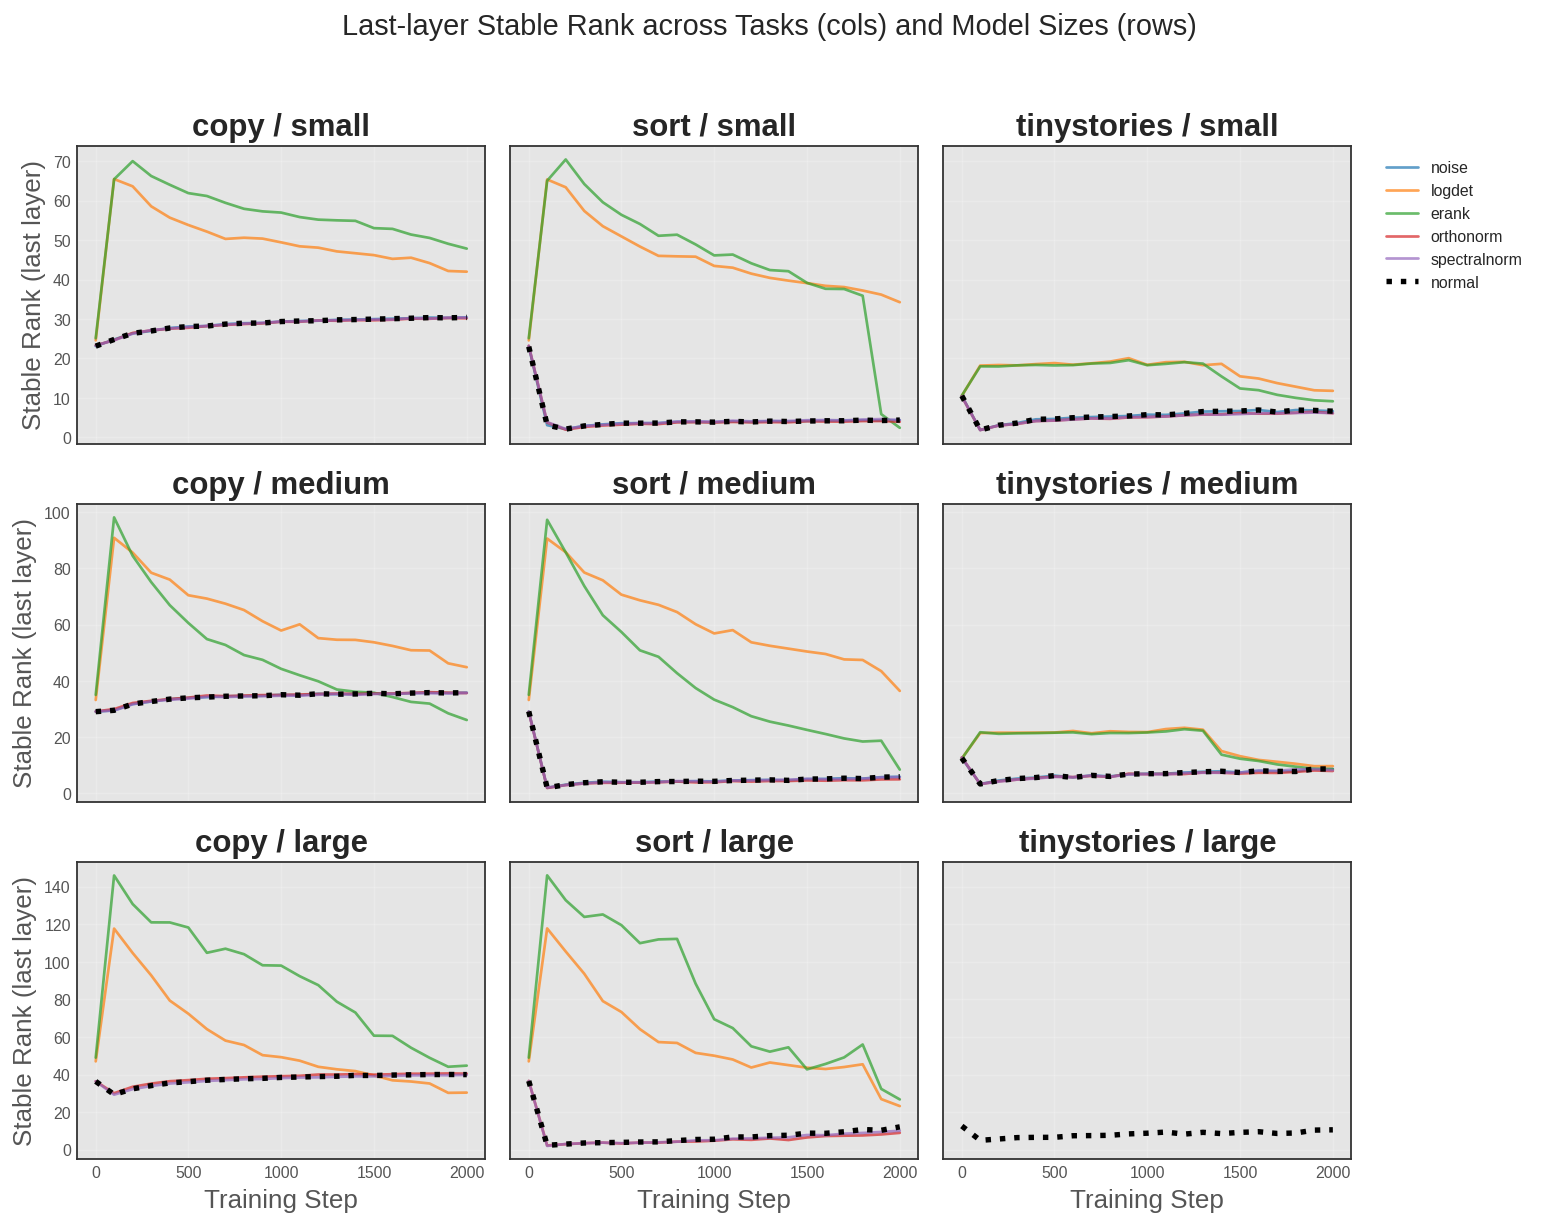

In [153]:
# plotting color map for reg schemes; ensure 'normal' stands out
DEFAULT_REG_ORDER = ['noise', 'logdet', 'erank', 'orthonorm', 'spectralnorm', 'normal']
DEFAULT_COLORS = sns.color_palette('tab10', n_colors=len(DEFAULT_REG_ORDER))

REG_COLOR_MAP = {k: DEFAULT_COLORS[i] for i, k in enumerate(DEFAULT_REG_ORDER)}

def reg_color(reg_name: str):
    return REG_COLOR_MAP.get(reg_name, 'gray')

def plot_last_layer_rank_grid(experiments: List[Dict],
                              tasks=('copy', 'sort', 'tinystories'),
                              sizes=('small', 'medium', 'large'),
                              reg_list=('noise', 'logdet', 'erank', 'orthonorm', 'spectralnorm', 'normal'),
                              dataset_size_field='dataset_size',
                              savepath: Optional[str]=None):
    """
    Create a 3x3 grid: columns = tasks, rows = sizes.
    Each subplot plots curves (over training step) for each reg in reg_list.
    'normal' is plotted last (thicker/darker).
    """
    n_rows = len(sizes)
    n_cols = len(tasks)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.2*n_rows), sharex='col', sharey='row')
    fig.suptitle("Last-layer Stable Rank across Tasks (cols) and Model Sizes (rows)", fontsize=16)

    for r_idx, size in enumerate(sizes):
        for c_idx, task in enumerate(tasks):
            ax = axes[r_idx][c_idx] if (n_rows > 1 and n_cols > 1) else (axes[c_idx] if n_rows==1 else axes[r_idx])
            # plot each reg curve
            # we'll gather experiments that match task,size and each reg
            for reg in reg_list:
                exps = find_experiments(experiments, task=task, arch=size, dataset_size="medium", reg_scheme=reg)
                if len(exps) == 0:
                    print(f"found no experiments for {task}, ds size {size}, reg scheme {reg}")
                    continue
                # if multiple experiments for same spec average them
                ranks = []
                steps = None
                for e in exps:
                    arr = extract_last_layer_stable_rank(e['metrics'])
                    s = extract_steps(e['metrics'])
                    if steps is None:
                        steps = s
                    if len(s) != 21 and len(s) != 11:
                        print(len(s))
                        continue
                    # align lengths if necessary (cut to min)
                    min_len = min(len(arr), len(steps))
                    ranks.append(arr[:min_len])
                # pad/average
                if len(ranks) == 0:
                    continue
                ranks = np.vstack([r for r in ranks])
                mean_rank = np.nanmean(ranks, axis=0)
                steps = steps[:mean_rank.shape[0]]

                # styling: normal last & bold
                if reg == 'normal':
                    ax.plot(steps, mean_rank, label=reg, color='black',
                            linewidth=LINEWIDTH_NORMAL, alpha=1.0, linestyle="dotted")
                else:
                    ax.plot(steps, mean_rank, label=reg, color=reg_color(reg),
                            linewidth=LINEWIDTH_OTHER, alpha=ALPHA_OTHER)

            ax.set_title(f"{task} / {size}")
            if r_idx == n_rows - 1:
                ax.set_xlabel("Training Step")
            if c_idx == 0:
                ax.set_ylabel("Stable Rank (last layer)")
            if r_idx == 0 and c_idx == n_cols - 1:
                # put legend in top-right subplot to spare space
                ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if savepath:
        plt.savefig(savepath, dpi=200)
    plt.show()

plot_last_layer_rank_grid(experiments, savepath="figs/last_layer_grid.png")

no data for task=copy, size=small, regime=collapseEarlyThenExpandLate, weight=1.0
no data for task=copy, size=small, regime=collapseEarlyOnly, weight=1.0
no data for task=copy, size=small, regime=expandEarlyThenCollapseLate, weight=1.0
no data for task=copy, size=small, regime=expandEarlyOnly, weight=1.0
no data for task=copy, size=small, regime=normal, weight=1.0
no data for task=copy, size=medium, regime=collapseEarlyThenExpandLate, weight=1.0
no data for task=copy, size=medium, regime=collapseEarlyOnly, weight=1.0
no data for task=copy, size=medium, regime=expandEarlyThenCollapseLate, weight=1.0
no data for task=copy, size=medium, regime=expandEarlyOnly, weight=1.0
no data for task=copy, size=medium, regime=normal, weight=1.0
no data for task=copy, size=large, regime=collapseEarlyThenExpandLate, weight=1.0
no data for task=copy, size=large, regime=collapseEarlyOnly, weight=1.0
no data for task=copy, size=large, regime=expandEarlyThenCollapseLate, weight=1.0
no data for task=copy, si

/tmp/ipython-input-280229840.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


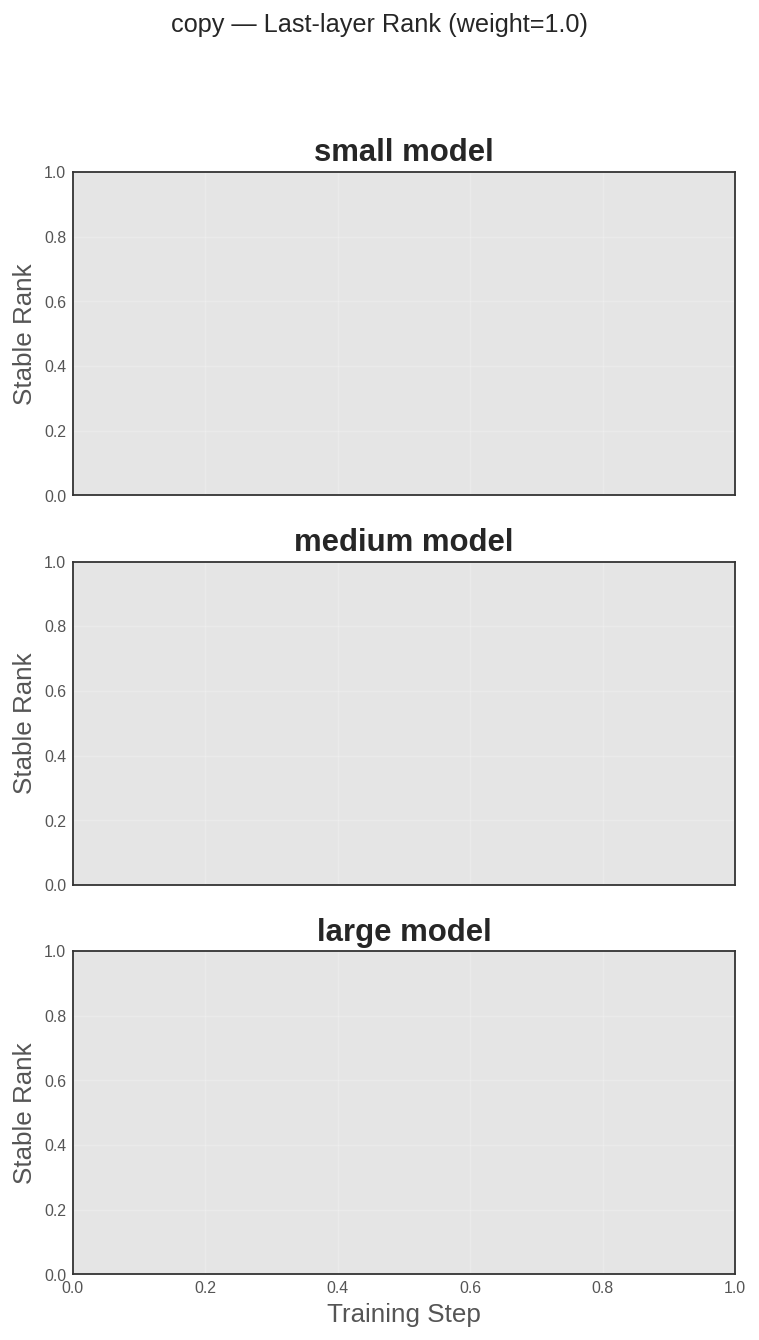

no data for task=copy, size=small, regime=collapseEarlyThenExpandLate, weight=0.1
no data for task=copy, size=small, regime=collapseEarlyOnly, weight=0.1
no data for task=copy, size=small, regime=expandEarlyThenCollapseLate, weight=0.1
no data for task=copy, size=small, regime=expandEarlyOnly, weight=0.1
no data for task=copy, size=small, regime=normal, weight=0.1
no data for task=copy, size=medium, regime=collapseEarlyThenExpandLate, weight=0.1
no data for task=copy, size=medium, regime=collapseEarlyOnly, weight=0.1
no data for task=copy, size=medium, regime=expandEarlyThenCollapseLate, weight=0.1
no data for task=copy, size=medium, regime=expandEarlyOnly, weight=0.1
no data for task=copy, size=medium, regime=normal, weight=0.1
no data for task=copy, size=large, regime=collapseEarlyThenExpandLate, weight=0.1
no data for task=copy, size=large, regime=collapseEarlyOnly, weight=0.1
no data for task=copy, size=large, regime=expandEarlyThenCollapseLate, weight=0.1
no data for task=copy, si

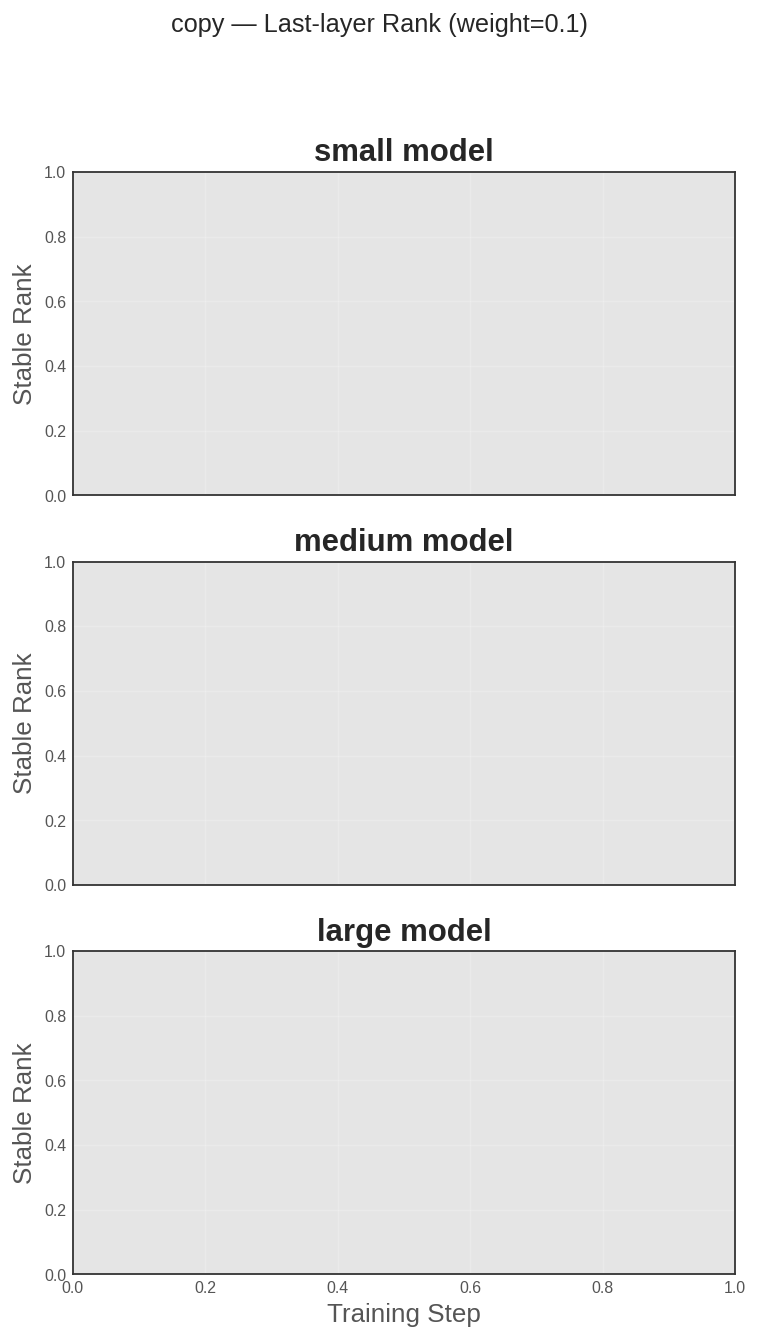

no data for task=copy, size=small, regime=normal, weight=0.01
no data for task=copy, size=medium, regime=normal, weight=0.01
no data for task=copy, size=large, regime=collapseEarlyThenExpandLate, weight=0.01
no data for task=copy, size=large, regime=collapseEarlyOnly, weight=0.01
no data for task=copy, size=large, regime=expandEarlyOnly, weight=0.01
no data for task=copy, size=large, regime=normal, weight=0.01


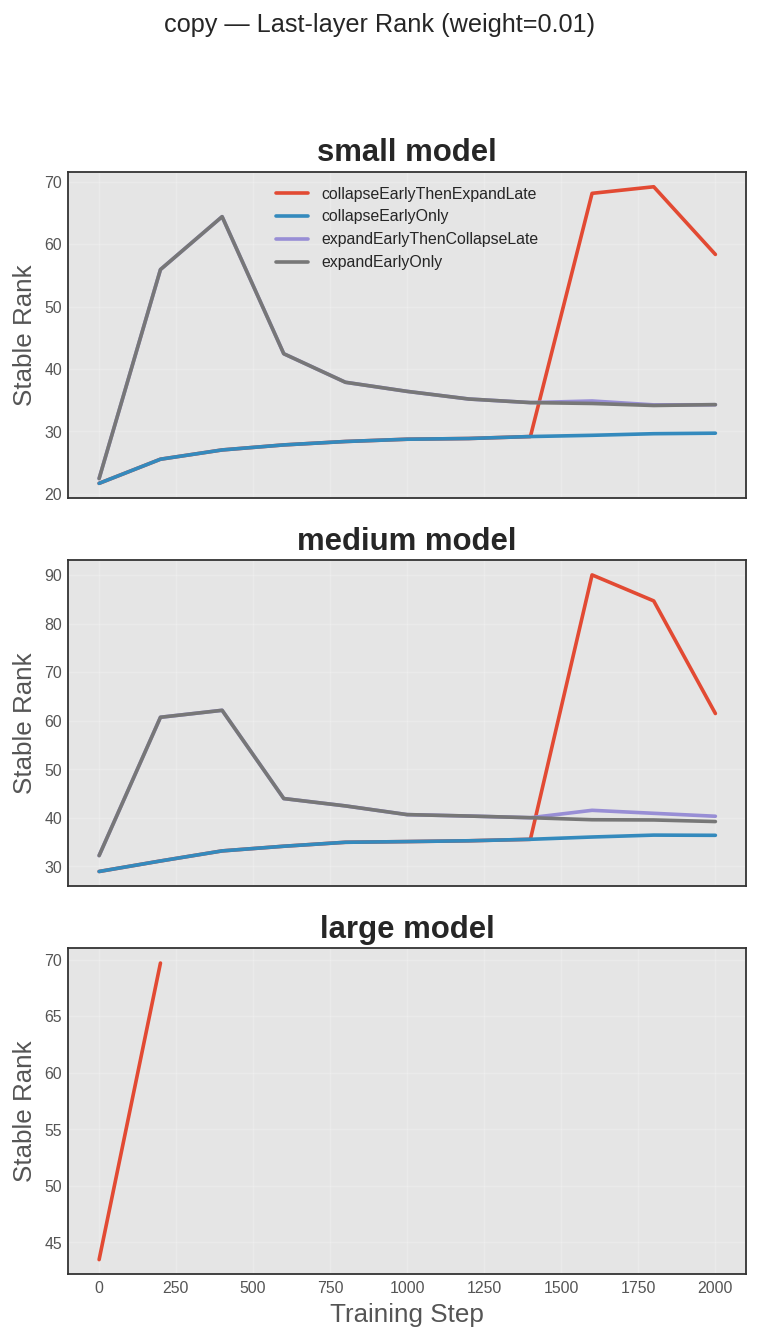

no data for task=sort, size=small, regime=collapseEarlyThenExpandLate, weight=1.0
no data for task=sort, size=small, regime=collapseEarlyOnly, weight=1.0
no data for task=sort, size=small, regime=expandEarlyThenCollapseLate, weight=1.0
no data for task=sort, size=small, regime=expandEarlyOnly, weight=1.0
no data for task=sort, size=small, regime=normal, weight=1.0
no data for task=sort, size=medium, regime=collapseEarlyThenExpandLate, weight=1.0
no data for task=sort, size=medium, regime=collapseEarlyOnly, weight=1.0
no data for task=sort, size=medium, regime=expandEarlyThenCollapseLate, weight=1.0
no data for task=sort, size=medium, regime=expandEarlyOnly, weight=1.0
no data for task=sort, size=medium, regime=normal, weight=1.0
no data for task=sort, size=large, regime=collapseEarlyThenExpandLate, weight=1.0
no data for task=sort, size=large, regime=collapseEarlyOnly, weight=1.0
no data for task=sort, size=large, regime=expandEarlyThenCollapseLate, weight=1.0
no data for task=sort, si

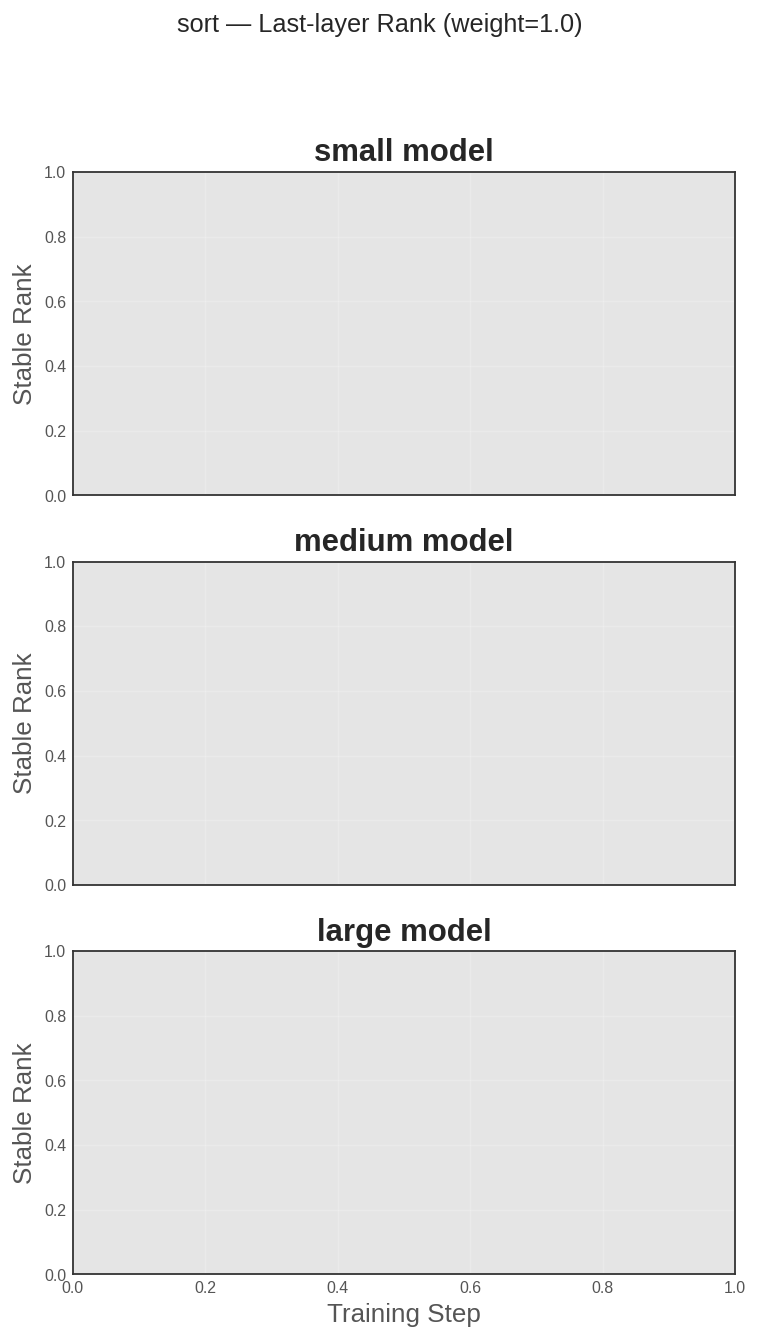

no data for task=sort, size=small, regime=collapseEarlyThenExpandLate, weight=0.1
no data for task=sort, size=small, regime=collapseEarlyOnly, weight=0.1
no data for task=sort, size=small, regime=expandEarlyThenCollapseLate, weight=0.1
no data for task=sort, size=small, regime=expandEarlyOnly, weight=0.1
no data for task=sort, size=small, regime=normal, weight=0.1
no data for task=sort, size=medium, regime=collapseEarlyThenExpandLate, weight=0.1
no data for task=sort, size=medium, regime=collapseEarlyOnly, weight=0.1
no data for task=sort, size=medium, regime=expandEarlyThenCollapseLate, weight=0.1
no data for task=sort, size=medium, regime=expandEarlyOnly, weight=0.1
no data for task=sort, size=medium, regime=normal, weight=0.1
no data for task=sort, size=large, regime=collapseEarlyThenExpandLate, weight=0.1
no data for task=sort, size=large, regime=collapseEarlyOnly, weight=0.1
no data for task=sort, size=large, regime=expandEarlyThenCollapseLate, weight=0.1
no data for task=sort, si

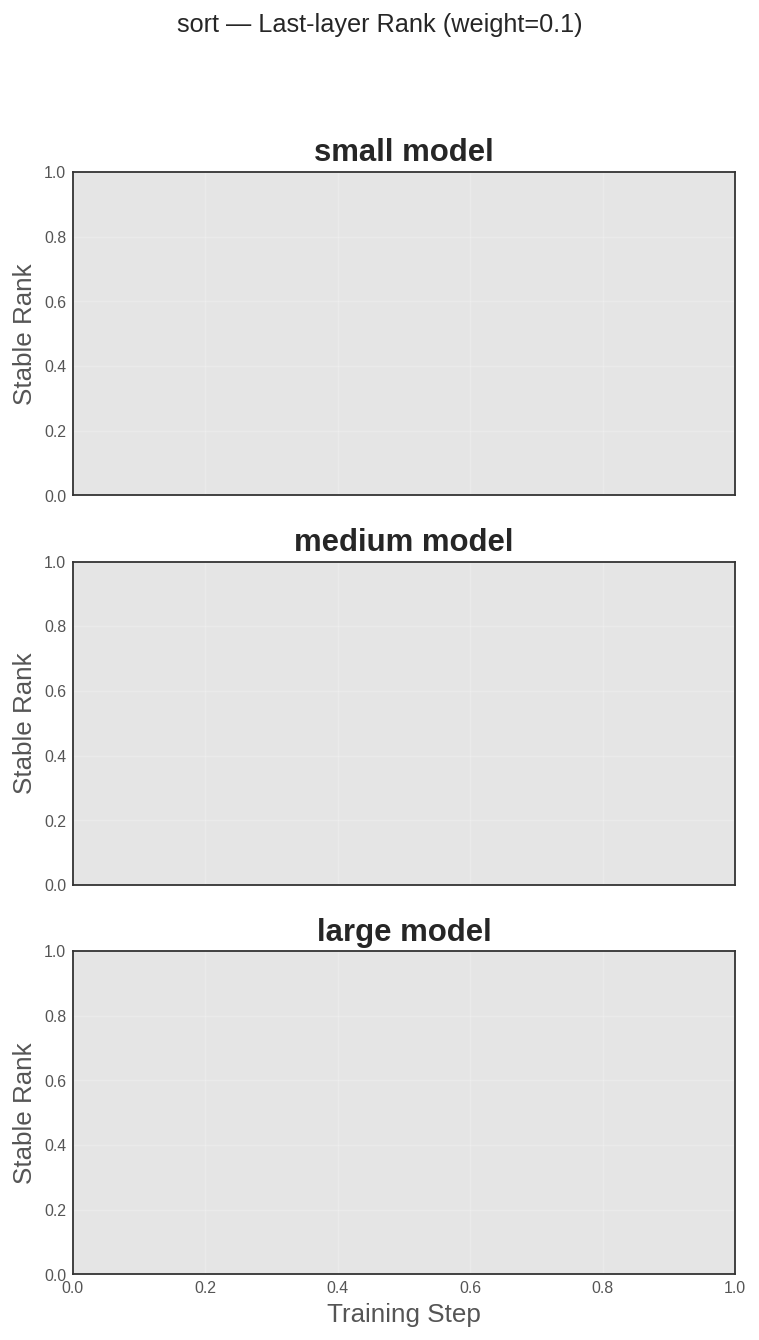

no data for task=sort, size=small, regime=normal, weight=0.01
no data for task=sort, size=medium, regime=normal, weight=0.01
no data for task=sort, size=large, regime=collapseEarlyThenExpandLate, weight=0.01
no data for task=sort, size=large, regime=collapseEarlyOnly, weight=0.01
no data for task=sort, size=large, regime=expandEarlyThenCollapseLate, weight=0.01
no data for task=sort, size=large, regime=expandEarlyOnly, weight=0.01
no data for task=sort, size=large, regime=normal, weight=0.01


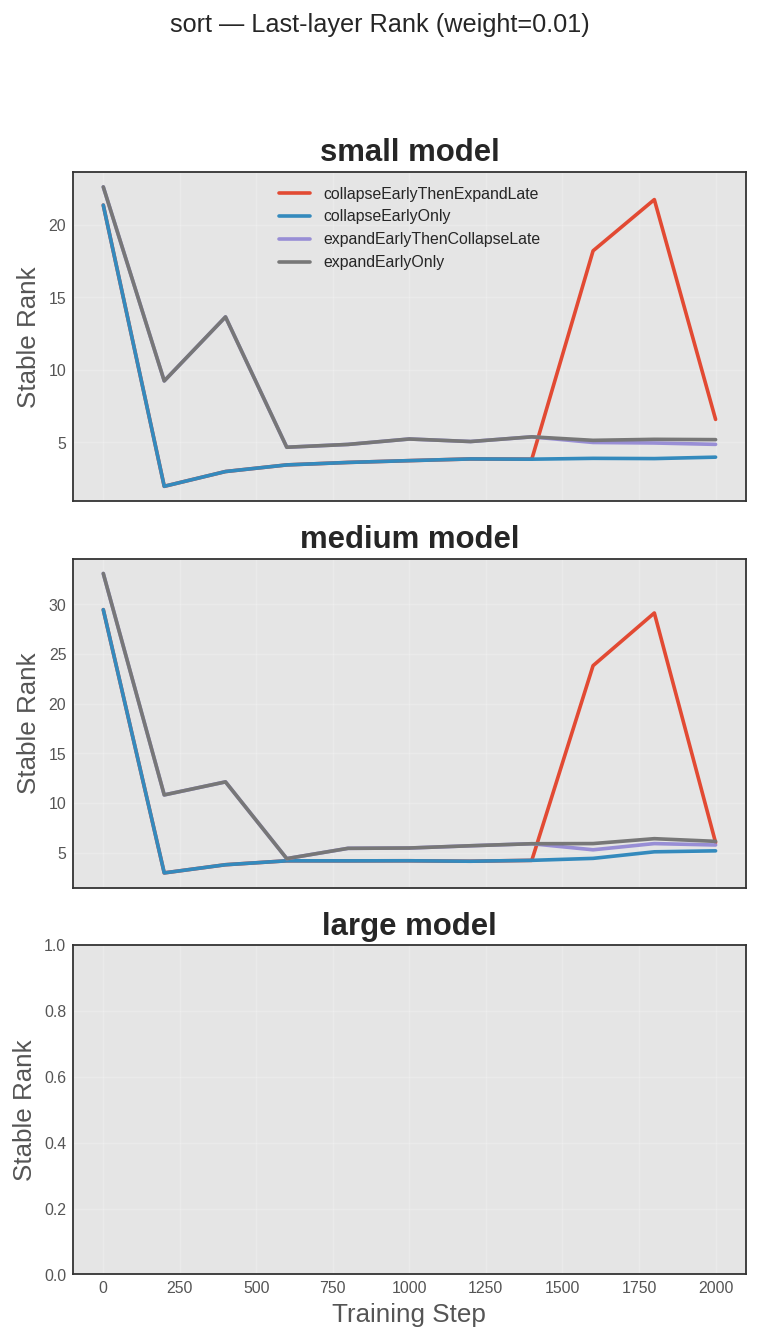

no data for task=tinystories, size=small, regime=collapseEarlyThenExpandLate, weight=1.0
no data for task=tinystories, size=small, regime=collapseEarlyOnly, weight=1.0
no data for task=tinystories, size=small, regime=expandEarlyThenCollapseLate, weight=1.0
no data for task=tinystories, size=small, regime=expandEarlyOnly, weight=1.0
no data for task=tinystories, size=small, regime=normal, weight=1.0
no data for task=tinystories, size=medium, regime=collapseEarlyThenExpandLate, weight=1.0
no data for task=tinystories, size=medium, regime=collapseEarlyOnly, weight=1.0
no data for task=tinystories, size=medium, regime=expandEarlyThenCollapseLate, weight=1.0
no data for task=tinystories, size=medium, regime=expandEarlyOnly, weight=1.0
no data for task=tinystories, size=medium, regime=normal, weight=1.0
no data for task=tinystories, size=large, regime=collapseEarlyThenExpandLate, weight=1.0
no data for task=tinystories, size=large, regime=collapseEarlyOnly, weight=1.0
no data for task=tinyst

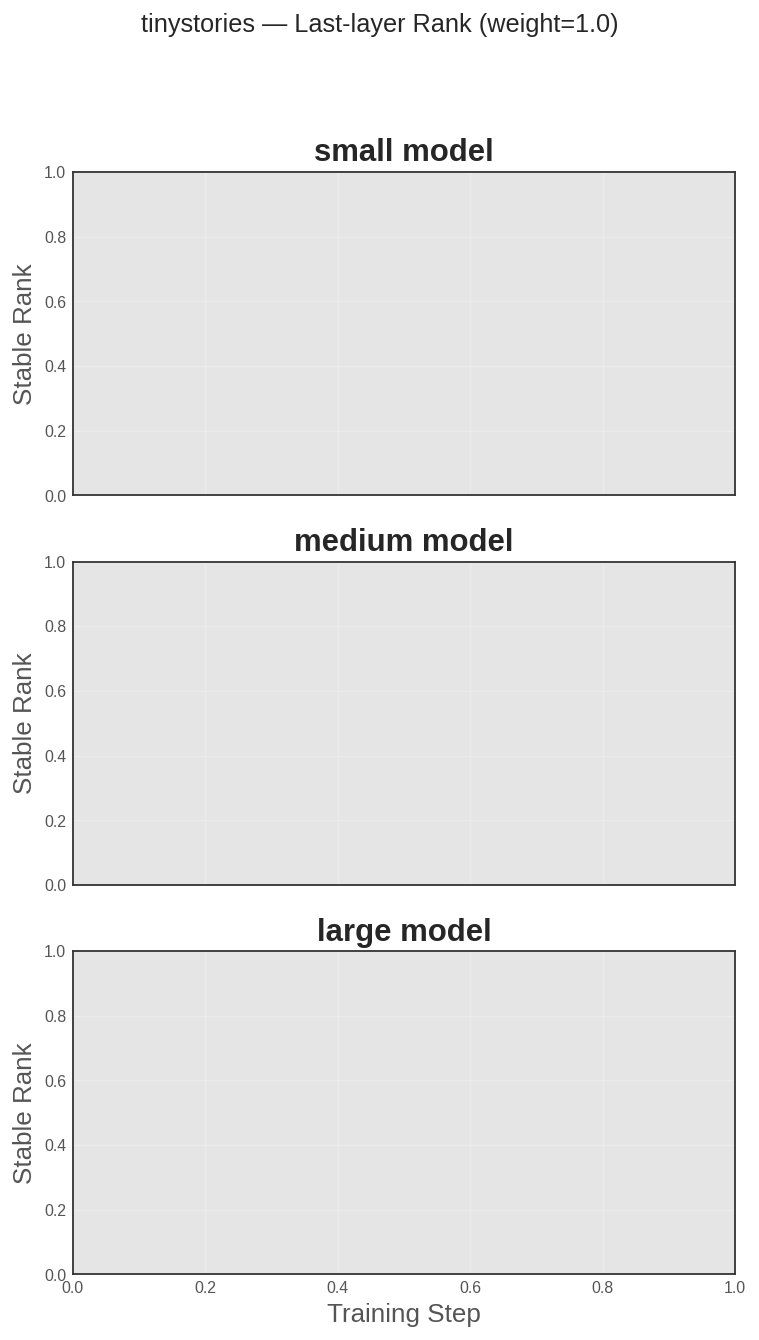

no data for task=tinystories, size=small, regime=collapseEarlyThenExpandLate, weight=0.1
no data for task=tinystories, size=small, regime=collapseEarlyOnly, weight=0.1
no data for task=tinystories, size=small, regime=expandEarlyThenCollapseLate, weight=0.1
no data for task=tinystories, size=small, regime=expandEarlyOnly, weight=0.1
no data for task=tinystories, size=small, regime=normal, weight=0.1
no data for task=tinystories, size=medium, regime=collapseEarlyThenExpandLate, weight=0.1
no data for task=tinystories, size=medium, regime=collapseEarlyOnly, weight=0.1
no data for task=tinystories, size=medium, regime=expandEarlyThenCollapseLate, weight=0.1
no data for task=tinystories, size=medium, regime=expandEarlyOnly, weight=0.1
no data for task=tinystories, size=medium, regime=normal, weight=0.1
no data for task=tinystories, size=large, regime=collapseEarlyThenExpandLate, weight=0.1
no data for task=tinystories, size=large, regime=collapseEarlyOnly, weight=0.1
no data for task=tinyst

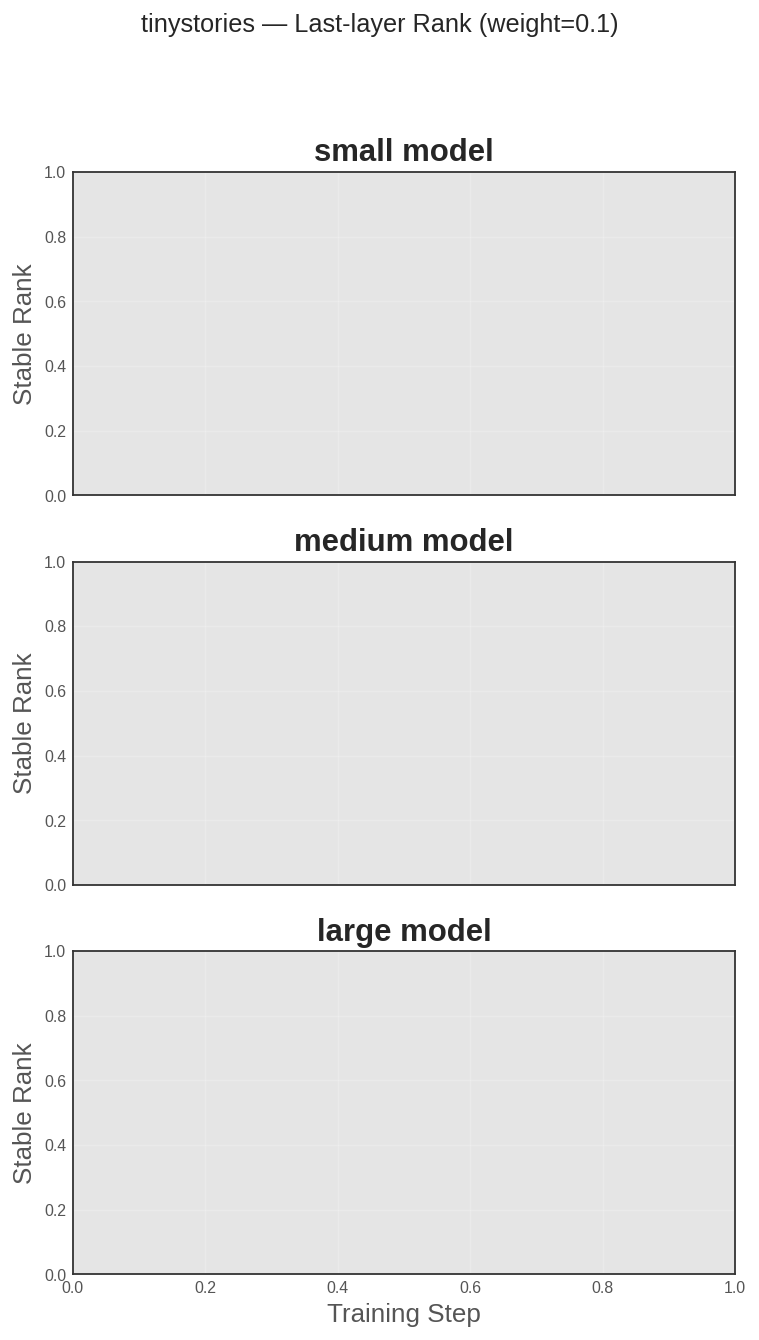

no data for task=tinystories, size=small, regime=normal, weight=0.01
no data for task=tinystories, size=medium, regime=normal, weight=0.01
no data for task=tinystories, size=large, regime=collapseEarlyThenExpandLate, weight=0.01
no data for task=tinystories, size=large, regime=collapseEarlyOnly, weight=0.01
no data for task=tinystories, size=large, regime=expandEarlyThenCollapseLate, weight=0.01
no data for task=tinystories, size=large, regime=expandEarlyOnly, weight=0.01
no data for task=tinystories, size=large, regime=normal, weight=0.01


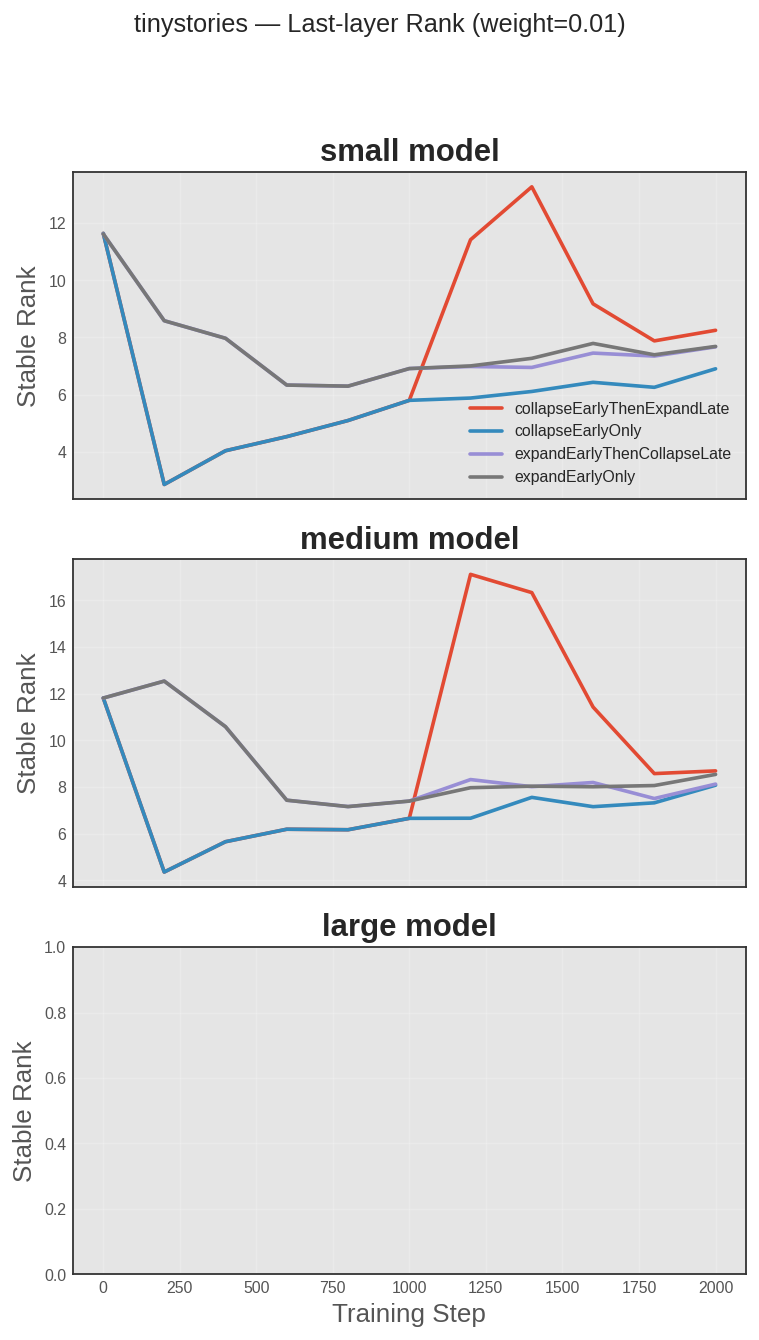

In [152]:
def plot_ranks_by_weight(
    experiments: List[Dict],
    tasks=('copy','sort','tinystories'),
    regimes=('collapseEarlyThenExpandLate','collapseEarlyOnly',
             'expandEarlyThenCollapseLate','expandEarlyOnly','normal'),
    sizes=('small','medium','large'),
    weights=(1.0, 0.1, 0.01),
    save_dir: Optional[str]=None
):
    """
    For each task AND weight, create a figure.
    Rows = sizes.
    Each subplot overlays curves for all regimes.
    Regimes appear in the legend.
    """
    for task in tasks:
        for w in weights:
            fig, axes = plt.subplots(
                len(sizes), 1,
                figsize=(6, 3.5*len(sizes)),
                sharex=True, sharey=False
            )
            fig.suptitle(f"{task} — Last-layer Rank (weight={w})", fontsize=14)

            # ensure axes is always iterable
            if len(sizes) == 1:
                axes = [axes]

            for i_row, size in enumerate(sizes):
                ax = axes[i_row]

                for regime in regimes:
                    exps = find_experiments(
                        experiments,
                        task=task,
                        arch=size,
                        dataset_size="medium",
                        reg_scheme=regime,
                        weight=w
                    )

                    if len(exps) == 0:
                        print(f"no data for task={task}, size={size}, regime={regime}, weight={w}")
                        continue

                    ranks = []
                    steps = None

                    for e in exps:
                        try:
                            arr = extract_last_layer_stable_rank(e["metrics"])
                            s   = extract_steps(e["metrics"])
                            min_len = min(len(arr), len(s))
                            if steps is None:
                                steps = s[:min_len]
                            ranks.append(arr[:min_len])
                        except Exception as exc:
                            print(f"Skipping bad run ({regime}): {exc}")
                            continue

                    if len(ranks) == 0:
                        continue

                    # align everything
                    min_len = min(len(r) for r in ranks)
                    ranks = np.vstack([r[:min_len] for r in ranks])
                    mean_rank = np.nanmean(ranks, axis=0)
                    ax.plot(steps[:min_len], mean_rank, label=regime, linewidth=2.0)

                ax.set_title(f"{size} model")
                if i_row == len(sizes)-1:
                    ax.set_xlabel("Training Step")
                ax.set_ylabel("Stable Rank")

                if i_row == 0:
                    ax.legend()

            plt.tight_layout(rect=[0,0,1,0.94])

            if save_dir:
                Path(save_dir).mkdir(parents=True, exist_ok=True)
                fname = f"{task}_weight_{w}_combined_regimes.png"
                plt.savefig(Path(save_dir)/fname, dpi=200)

            plt.show()
thing = []
thing.extend(filtered)
thing.extend(experiments)
plot_ranks_by_weight(filtered, save_dir="figs/weights_ranks")

In [132]:
def compute_generalization_table(experiments: List[Dict],
                                 task: str,
                                 regimes=('collapseEarlyThenExpandLate','collapseEarlyOnly','expandEarlyThenCollapseLate','expandEarlyOnly','normal'),
                                 sizes=('small','medium','large'),
                                 weight: Optional[str]=None,
                                 agg='final',  # 'final' (use last checkpoint) or 'mean_over_lastN'
                                 lastN: int=5,
                                 savepath: Optional[str]=None) -> pd.DataFrame:
    """
    Produce a DataFrame with rows = sizes and columns = regimes, containing numeric generalization gap.
    If multiple experiments exist for the same cell, their gaps are averaged.
    """
    table = pd.DataFrame(index=sizes, columns=regimes, dtype=float)
    for size in sizes:
        for regime in regimes:
            exps = find_experiments(experiments, task=task, arch=size, dataset_size="medium", reg_scheme=regime, weight=weight)
            gaps = []
            for e in exps:
                metrics = e['metrics']
                if len(metrics) == 0:
                    continue
                if agg == 'final':
                    m = metrics[-1]
                    gap = float(m.get('eval_acc', np.nan)) - float(m.get('train_acc', np.nan))
                else:
                    # mean over lastN checkpoints
                    last = metrics[-lastN:]
                    evals = np.array([float(x.get('eval_acc', np.nan)) for x in last])
                    trains = np.array([float(x.get('train_acc', np.nan)) for x in last])
                    gap = np.nanmean(evals - trains)
                gaps.append(gap)
            if len(gaps) > 0:
                table.loc[size, regime] = float(np.nanmean(gaps))
            else:
                table.loc[size, regime] = np.nan
    if savepath:
        table.to_csv(savepath)
    return table
df_copy = compute_generalization_table(filtered, task='copy', savepath='figs/gen_gap_copy.csv')
print(df_copy)


        collapseEarlyThenExpandLate  collapseEarlyOnly  \
small                      0.001060                0.0   
medium                     0.000000                0.0   
large                      0.008702                0.0   

        expandEarlyThenCollapseLate  expandEarlyOnly  normal  
small                      0.003978              0.0     0.0  
medium                     0.010091              0.0     0.0  
large                      0.427272              0.0     0.0  


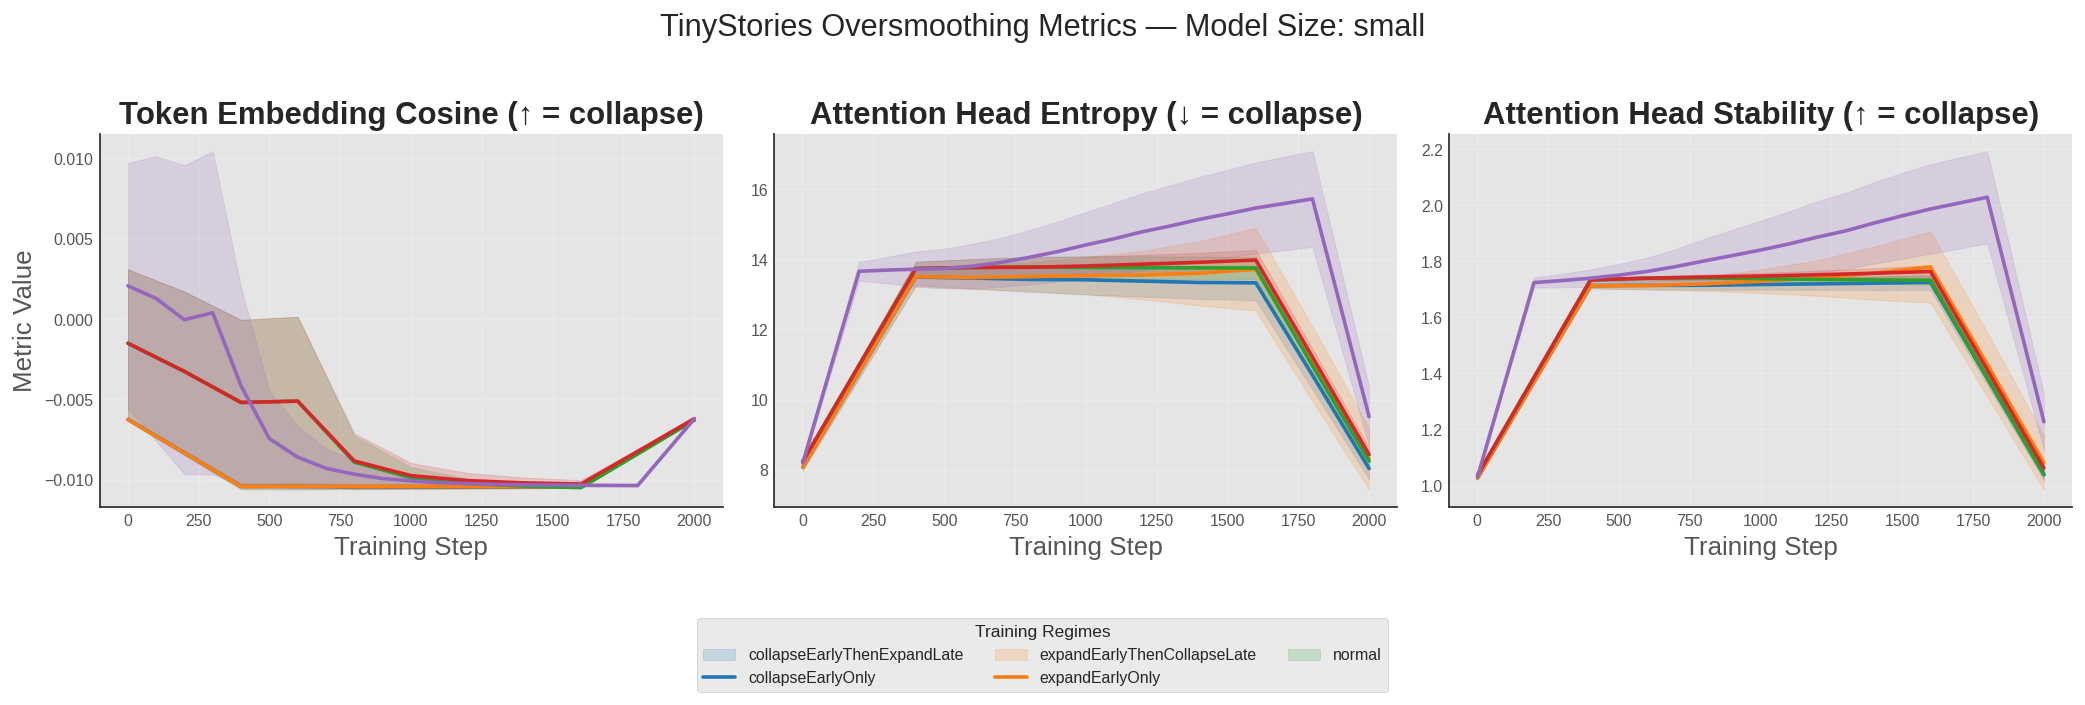

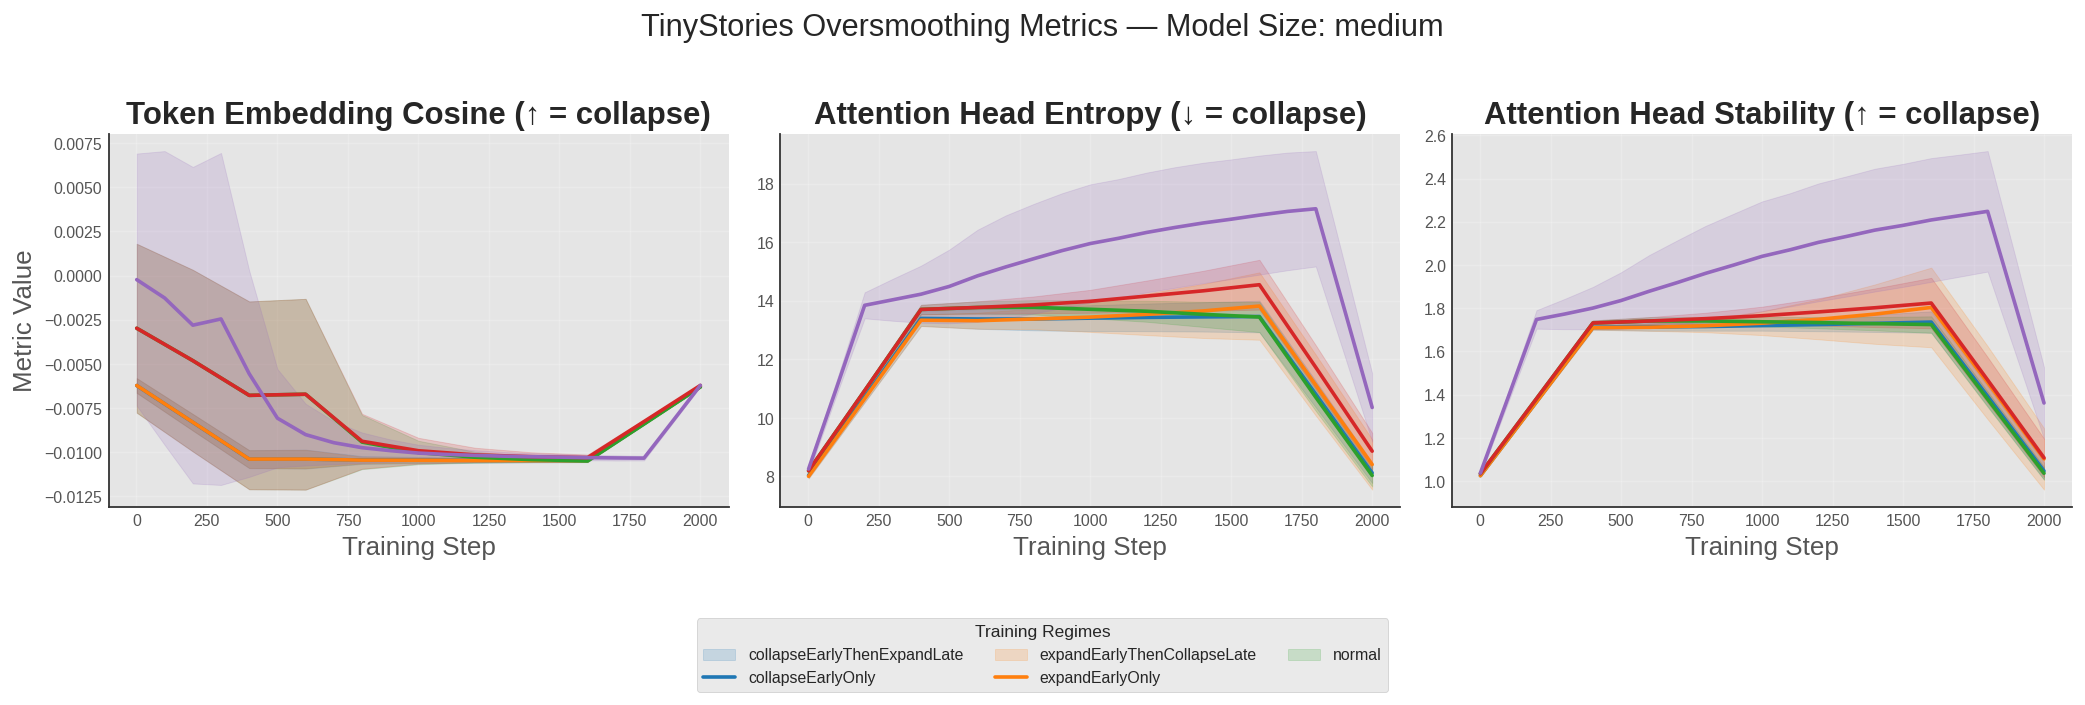

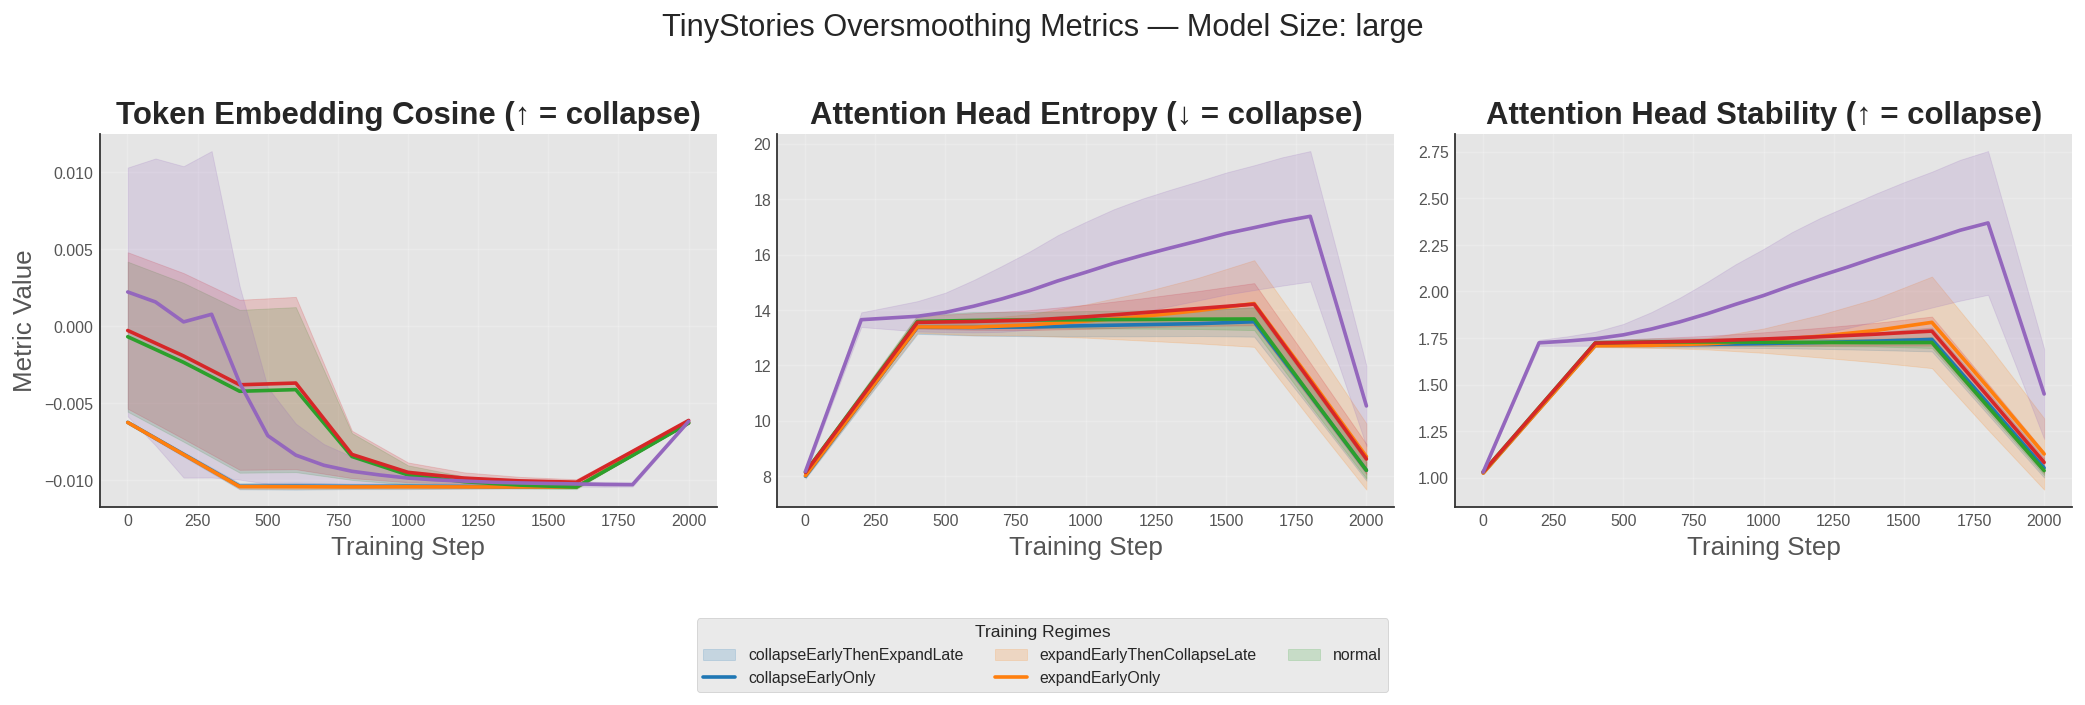

In [137]:
def plot_tinystories_oversmoothing_metrics(
    experiments: List[Dict],
    regimes=(
        'collapseEarlyThenExpandLate','collapseEarlyOnly',
        'expandEarlyThenCollapseLate','expandEarlyOnly','normal'
    ),
    sizes=('small','medium','large'),
    metrics_to_plot=('token_cosine_mean', 'attn_head_entropy_mean', 'attn_head_stable_mean'),
    savepath: Optional[str]=None,
    smooth_window=5
):

    task = "tinystories"

    # ---- Modern clean style ----
    plt.style.use("ggplot")
    plt.rcParams.update({
        "figure.dpi": 130,
        "font.size": 12,
        "axes.edgecolor": "#333333",
        "axes.titleweight": "semibold",
        "axes.grid": True,
        "grid.alpha": 0.20,
        "lines.linewidth": 2.0,
    })

    import seaborn as sns
    palette = sns.color_palette("tab10", n_colors=len(regimes))
    regime_colors = {reg: palette[i] for i, reg in enumerate(regimes)}

    # ------ smoothing helper ------
    def smooth(x, k):
        if len(x) < k:
            return x
        return np.convolve(x, np.ones(k)/k, mode="same")

    # ------ extract a single metric run ------
    def extract_metric_array(metrics_arr, metric_name):
        last_layer = get_last_layer_key(metrics_arr[0])
        out = []

        for m in metrics_arr:
            per = m["per_layer"][last_layer]

            if metric_name == "token_cosine_mean":
                out.append(per.get("token_cosine_mean", np.nan))

            elif metric_name == "attn_head_entropy_mean":
                attn = per.get("attn_mean_metrics", {})
                val = attn.get("head_entropy_mean",
                               attn.get("head_entropy", np.nan))
                if isinstance(val, (list, np.ndarray)):
                    val = np.nanmean(val)
                out.append(val)

            elif metric_name == "attn_head_stable_mean":
                attn = per.get("attn_mean_metrics", {})
                val = attn.get("head_stable_mean", np.nan)
                if isinstance(val, (list, np.ndarray)):
                    val = np.nanmean(val)
                out.append(val)

            else:
                out.append(np.nan)

        return np.array(out)


    # ---- Main loop ----
    for size in sizes:

        fig, axes = plt.subplots(
            1, len(metrics_to_plot),
            figsize=(5.4 * len(metrics_to_plot), 4.3),
            sharey=False
        )
        if len(metrics_to_plot) == 1:
            axes = [axes]

        fig.suptitle(
            f"TinyStories Oversmoothing Metrics — Model Size: {size}",
            fontsize=17,
            y=1.02
        )

        # Subplot pretty names
        clean_names = {
            "token_cosine_mean": "Token Embedding Cosine (↑ = collapse)",
            "attn_head_entropy_mean": "Attention Head Entropy (↓ = collapse)",
            "attn_head_stable_mean": "Attention Head Stability (↑ = collapse)"
        }

        for j, mname in enumerate(metrics_to_plot):
            ax = axes[j]

            for reg in regimes:
                exps = find_experiments(
                    experiments,
                    task=task,
                    arch=None,
                    dataset_size=size,
                    reg_scheme=reg
                )
                if len(exps) == 0:
                    continue

                runs = []
                steps = None

                for e in exps:
                    try:
                        arr = extract_metric_array(e["metrics"], mname)
                        s = extract_steps(e["metrics"])[:len(arr)]
                        runs.append(arr)
                        if steps is None: steps = s
                    except:
                        continue

                if len(runs) == 0:
                    continue

                # Align lengths
                L = min(len(r) for r in runs)
                stacked = np.vstack([r[:L] for r in runs])

                # Compute mean and std
                mean_series = np.nanmean(stacked, axis=0)
                std_series  = np.nanstd(stacked, axis=0)

                mean_series = smooth(mean_series, smooth_window)
                std_series  = smooth(std_series, smooth_window)

                # CI shading
                ax.fill_between(
                    steps[:L],
                    mean_series - std_series,
                    mean_series + std_series,
                    color=regime_colors[reg],
                    alpha=0.18
                )

                ax.plot(
                    steps[:L],
                    mean_series,
                    label=reg,
                    color=regime_colors[reg]
                )

            ax.set_title(clean_names.get(mname, mname))
            ax.set_xlabel("Training Step")
            if j == 0:
                ax.set_ylabel("Metric Value")

            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

        # One legend for whole figure
        fig.legend(
            regimes,
            title="Training Regimes",
            loc="upper center",
            bbox_to_anchor=(0.5, -0.05),
            ncol=3,
            frameon=True
        )

        plt.tight_layout()

        if savepath:
            Path(savepath).mkdir(parents=True, exist_ok=True)
            plt.savefig(
                Path(savepath)/f"tinystories_oversmooth_size_{size}.png",
                dpi=200, bbox_inches="tight"
            )

        plt.show()


plot_tinystories_oversmoothing_metrics(filtered, savepath="figs/tinystories_over.png")

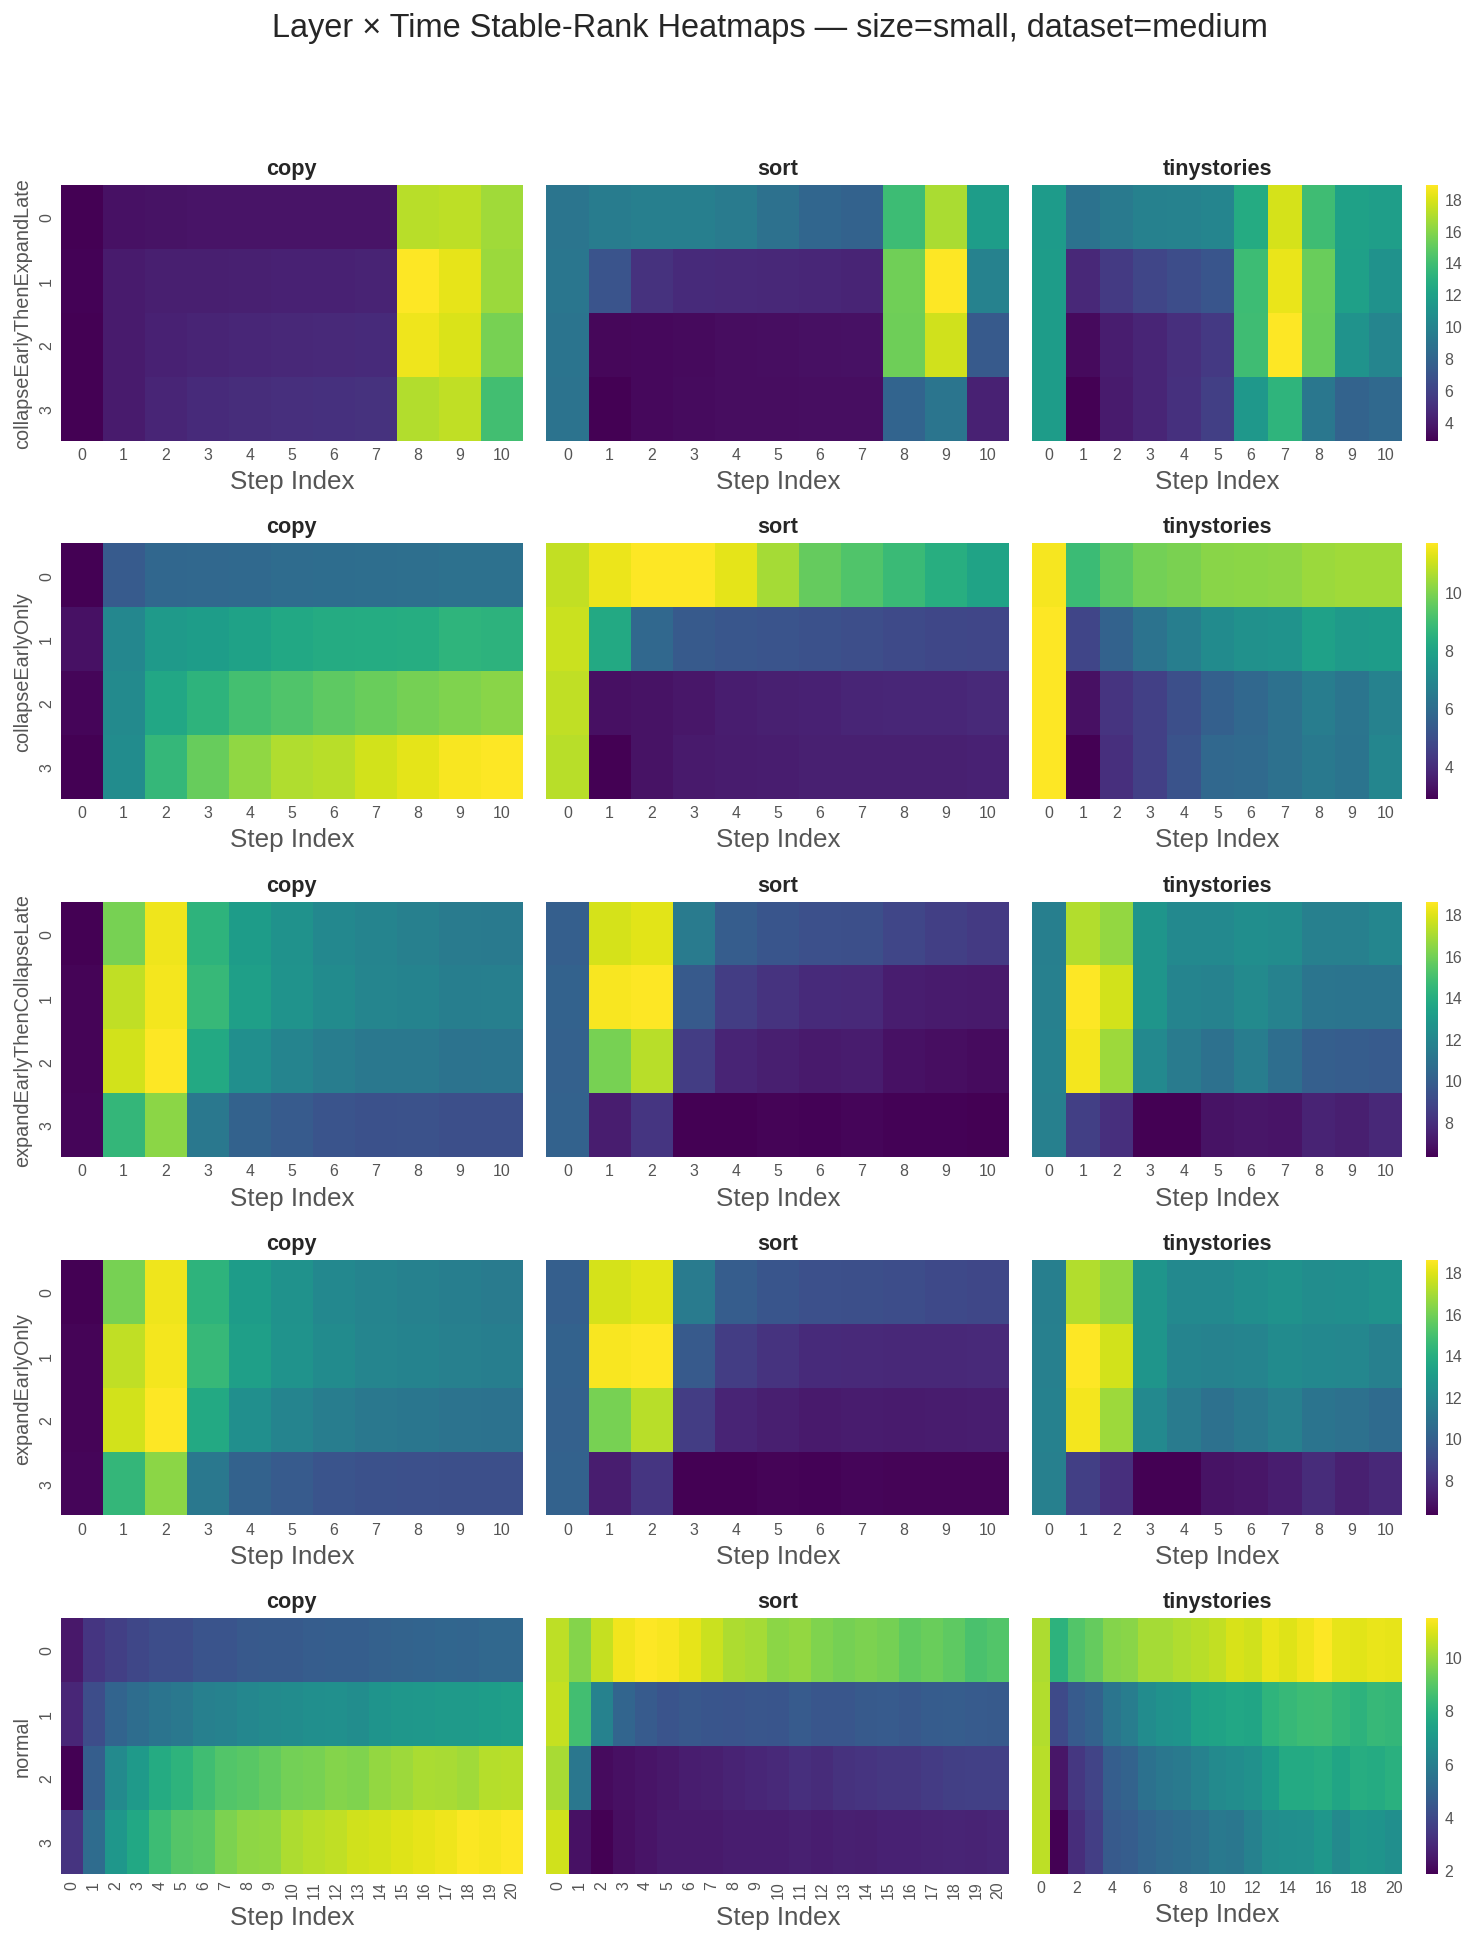

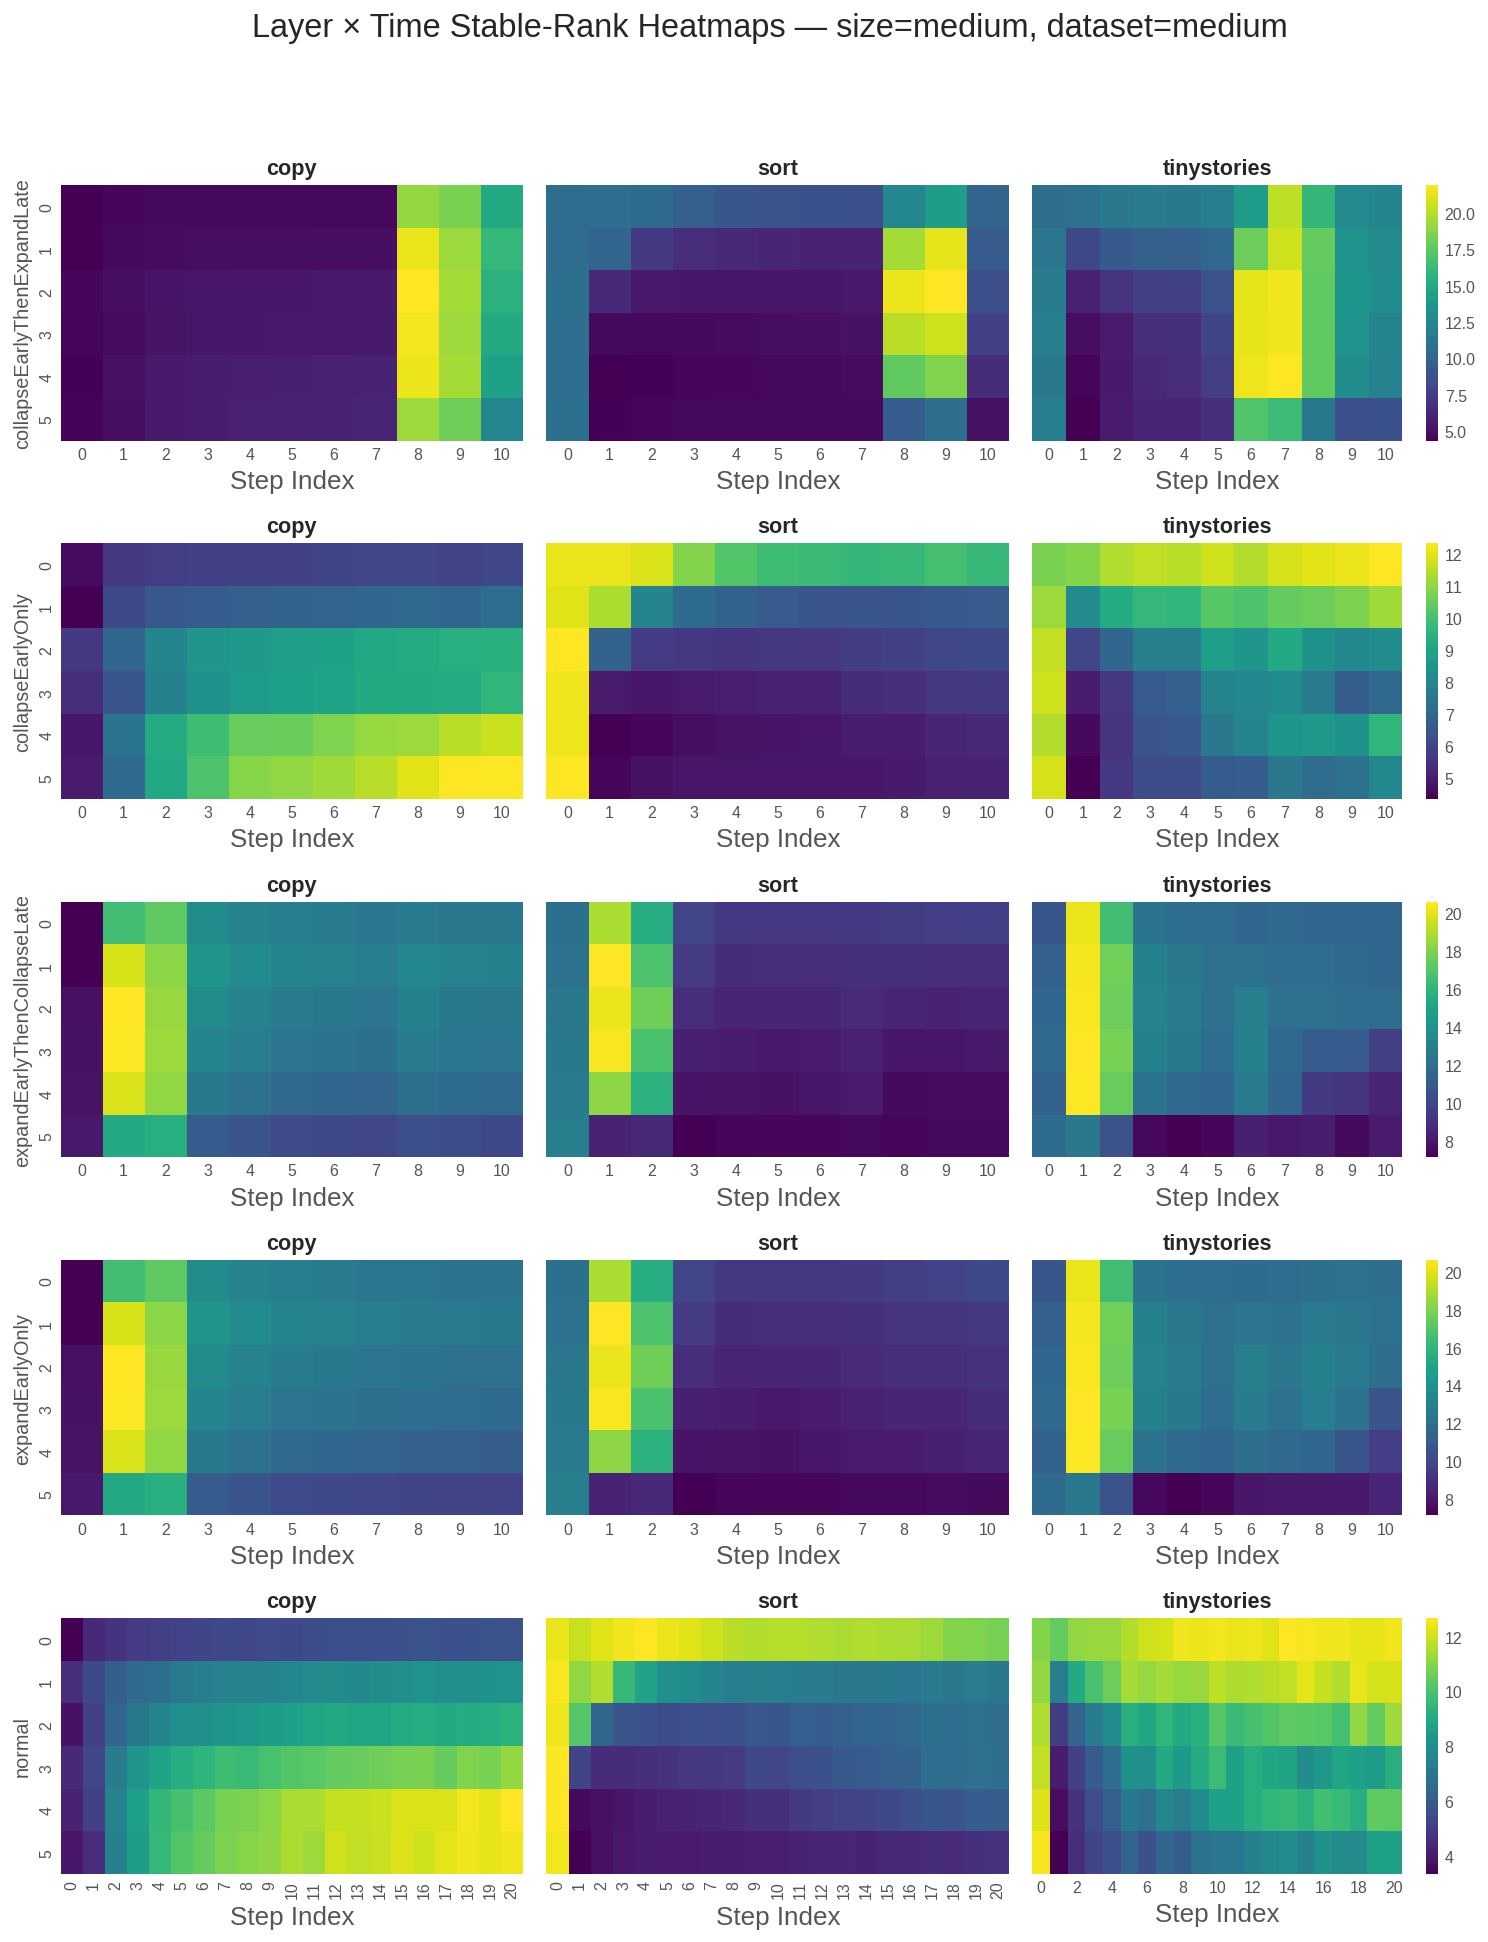

[NO DATA] task=copy, size=large, reg=collapseEarlyThenExpandLate
[NO DATA] task=sort, size=large, reg=collapseEarlyThenExpandLate
[NO DATA] task=tinystories, size=large, reg=collapseEarlyThenExpandLate
[NO DATA] task=copy, size=large, reg=collapseEarlyOnly
[NO DATA] task=sort, size=large, reg=collapseEarlyOnly
[NO DATA] task=tinystories, size=large, reg=collapseEarlyOnly
[NO DATA] task=sort, size=large, reg=expandEarlyThenCollapseLate
[NO DATA] task=tinystories, size=large, reg=expandEarlyThenCollapseLate
[NO DATA] task=copy, size=large, reg=expandEarlyOnly
[NO DATA] task=sort, size=large, reg=expandEarlyOnly
[NO DATA] task=tinystories, size=large, reg=expandEarlyOnly


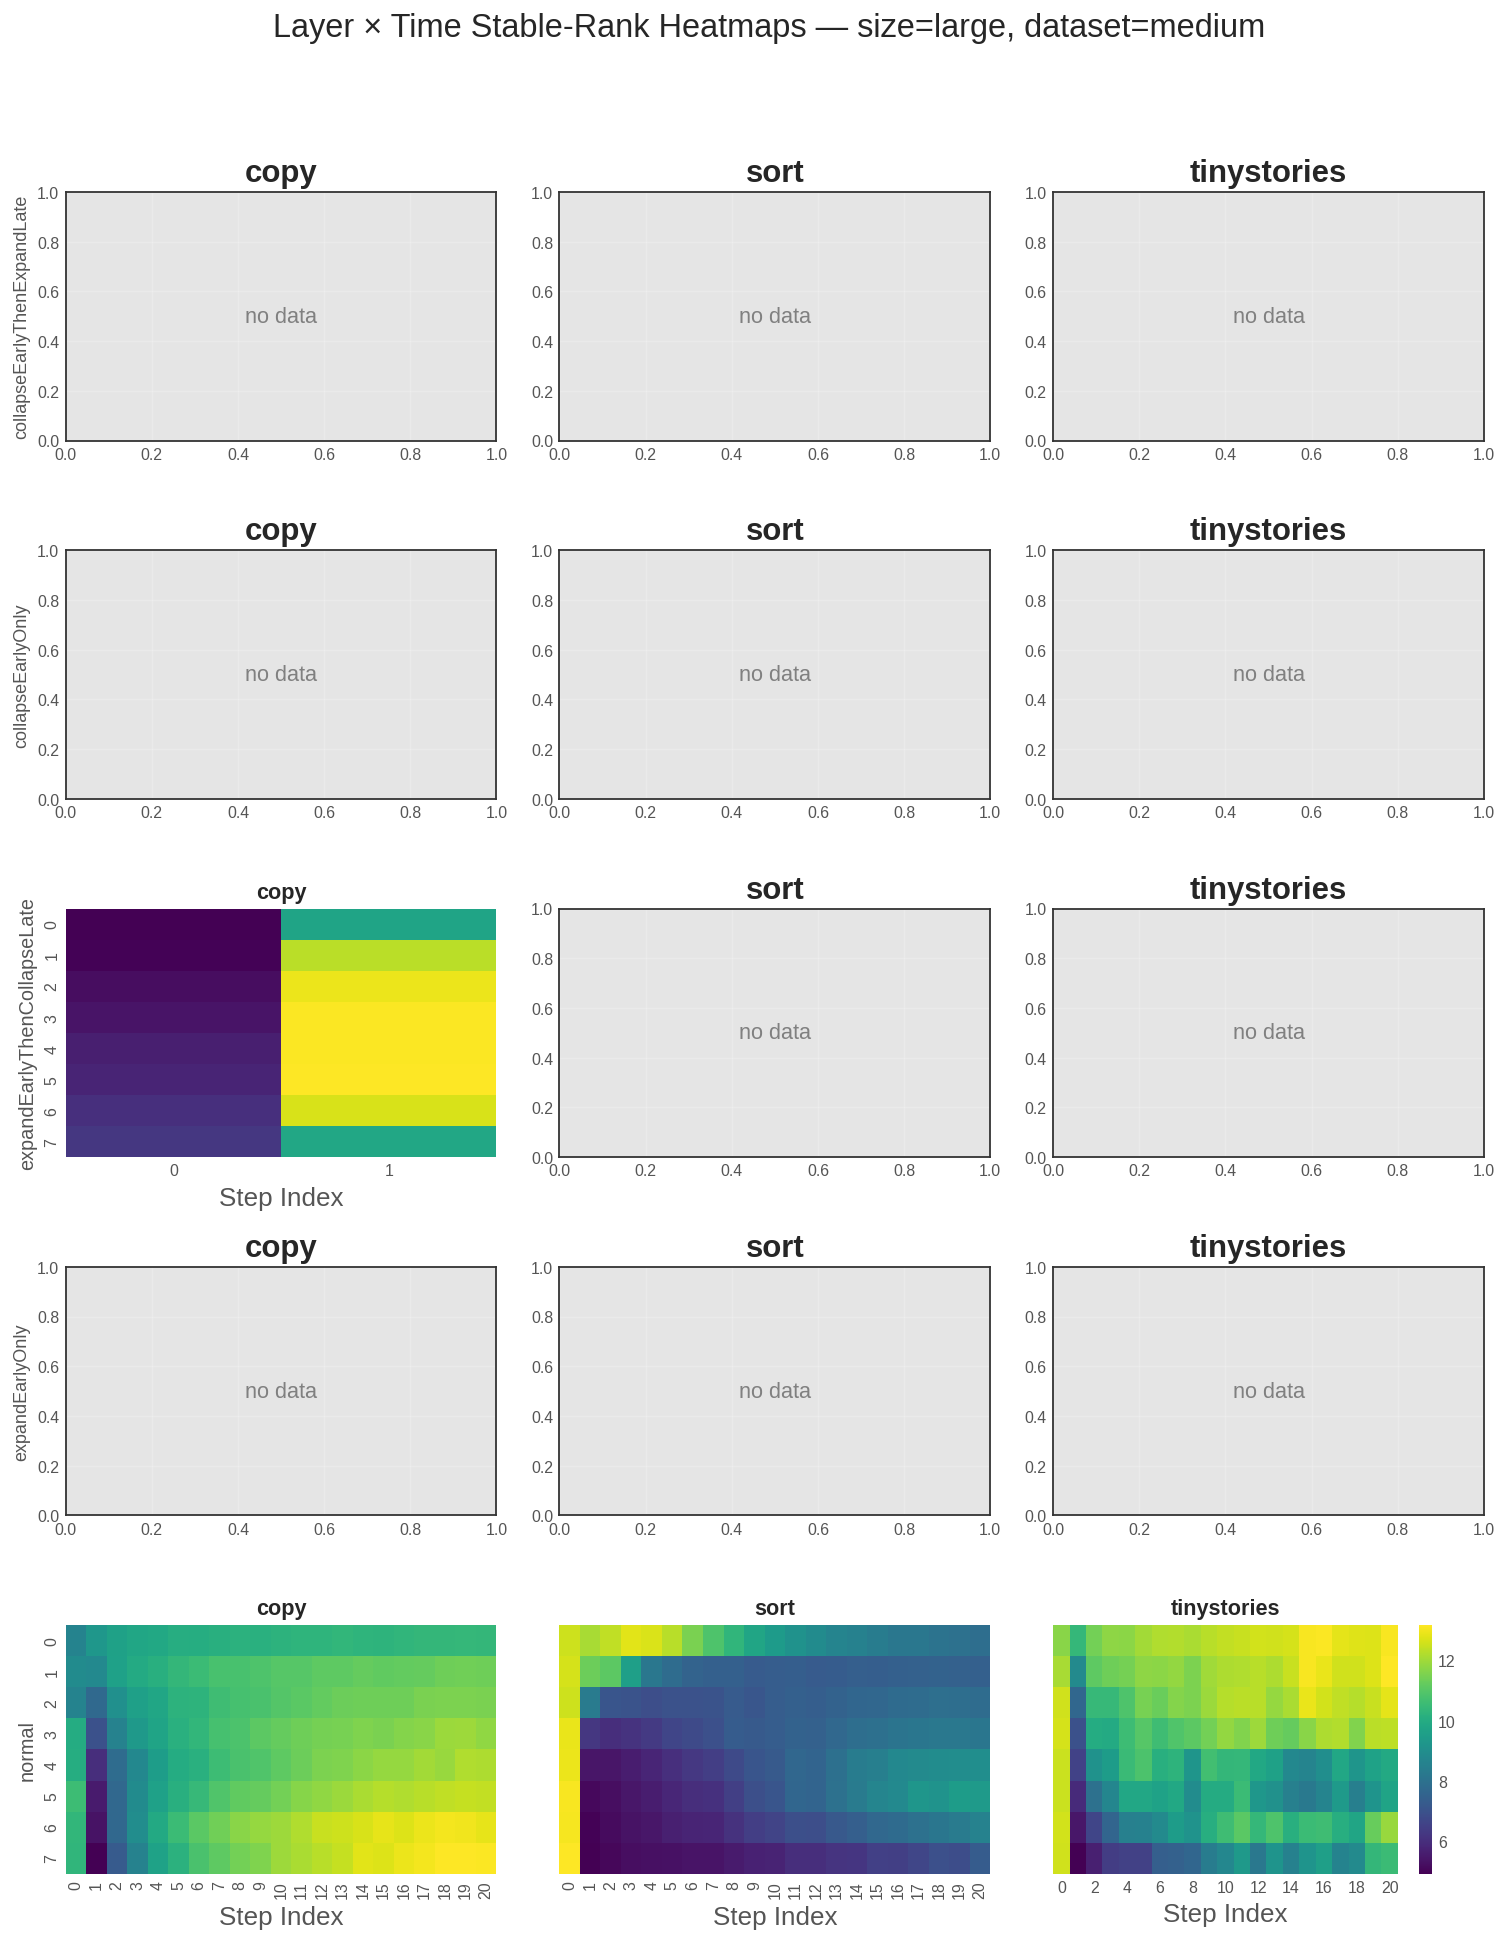

✓ Done generating heatmaps for all sizes and regimes.


In [157]:
def plot_interesting_heatmap_all_regimes(
    experiments: List[Dict],
    tasks=('copy','sort','tinystories'),
    sizes=('small','medium','large'),
    regimes=('collapseEarlyThenExpandLate',
             'collapseEarlyOnly',
             'expandEarlyThenCollapseLate',
             'expandEarlyOnly',
             'normal'),
    save_dir: str = "figs/heatmap_by_regime"
):
    """
    For each model size, create a figure:
        Rows   = regulation schemes
        Columns = tasks
    Each subplot: heatmap (layer × time) averaged across matching medium-dataset runs.
    """

    Path(save_dir).mkdir(parents=True, exist_ok=True)

    for size in sizes:
        nrows = len(regimes)
        ncols = len(tasks)

        fig, axes = plt.subplots(
            nrows, ncols,
            figsize=(4*ncols, 3.0*nrows),
            sharey=False, sharex=False
        )

        fig.suptitle(
            f"Layer × Time Stable-Rank Heatmaps — size={size}, dataset=medium",
            fontsize=18, y=0.995
        )

        for r, reg in enumerate(regimes):
            for c, task in enumerate(tasks):

                ax = axes[r][c]

                exps = find_experiments(
                    experiments,
                    task=task,
                    arch=size,
                    dataset_size="medium",   # <-- forced medium
                    reg_scheme=reg
                )

                if len(exps) == 0:
                    print(f"[NO DATA] task={task}, size={size}, reg={reg}")
                    ax.text(0.5, 0.5, "no data",
                            ha='center', va='center', color='gray')
                    ax.set_title(f"{task}")
                    if c == 0:
                        ax.set_ylabel(reg, fontsize=10)
                    continue

                # Get layer ordering
                first_metrics = exps[0]['metrics']
                if len(first_metrics) == 0:
                    ax.text(0.5,0.5,"no metrics",ha="center",va="center")
                    continue

                layer_names = sorted(first_metrics[0]["per_layer"].keys())
                L = len(layer_names)

                # Build matrices
                mats = []
                for e in exps:
                    metrics = e["metrics"]
                    T = len(metrics)
                    mat = np.full((L, T), np.nan)

                    for t, m in enumerate(metrics):
                        per = m["per_layer"]
                        for li, lname in enumerate(layer_names):
                            if lname in per:
                                mat[li, t] = per[lname]["activation_stable_rank"]

                    mats.append(mat)

                # Align time axis
                T_min = min(m.shape[1] for m in mats)
                mats = [m[:, :T_min] for m in mats]

                stacked = np.stack(mats, axis=2)
                avg_arr = np.nanmean(stacked, axis=2)

                # Plot
                sns.heatmap(
                    avg_arr,
                    ax=ax,
                    cmap="viridis",
                    cbar=(c == ncols - 1),
                    vmin=np.nanmin(avg_arr),
                    vmax=np.nanmax(avg_arr)
                )

                ax.set_title(task, fontsize=12)
                ax.set_xlabel("Step Index")

                if c == 0:
                    ax.set_ylabel(reg, fontsize=11)
                    ax.set_yticks(np.arange(L) + 0.5)
                    ax.set_yticklabels([l.replace("layer", "") for l in layer_names])
                else:
                    ax.set_yticks([])

        plt.tight_layout(rect=[0,0,0.98,0.96])
        outpath = Path(save_dir) / f"heatmaps_{size}.png"
        plt.savefig(outpath, dpi=220, bbox_inches='tight')
        plt.show()

    print("✓ Done generating heatmaps for all sizes and regimes.")


plot_interesting_heatmap_all_regimes(filtered + [x for x in experiments if x["regularizer"] == "normal"])

In [29]:
def get_steps(exp):
    return np.array([m['step'] for m in exp['metrics']])

def per_layer_array(exp, key, inner_key=None):
    """
    Build array: [n_layers, n_steps]
    key: e.g. 'activation_stable_rank'
    inner_key: only for nested metrics (e.g. weights->W1->stable_rank)
    """
    metrics = exp['metrics']
    first = metrics[0]['per_layer']
    layers = list(first.keys())
    L = len(layers)
    T = len(metrics)
    arr = np.zeros((L, T))

    for t, m in enumerate(metrics):
        for i, layer in enumerate(layers):
            if inner_key is None:
                arr[i, t] = m['per_layer'][layer][key]
            else:
                arr[i, t] = m['per_layer'][layer][key][inner_key]

    return arr, layers

In [30]:
def plot_layerwise_stable_rank(exp):
    steps = get_steps(exp)
    arr, layers = per_layer_array(exp, 'activation_stable_rank')

    plt.figure(figsize=(10, 6))
    sns.heatmap(arr, cmap='viridis', xticklabels=50, yticklabels=layers)
    plt.title("Per-Layer Stable Rank (Activations)")
    plt.xlabel("Training Step")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

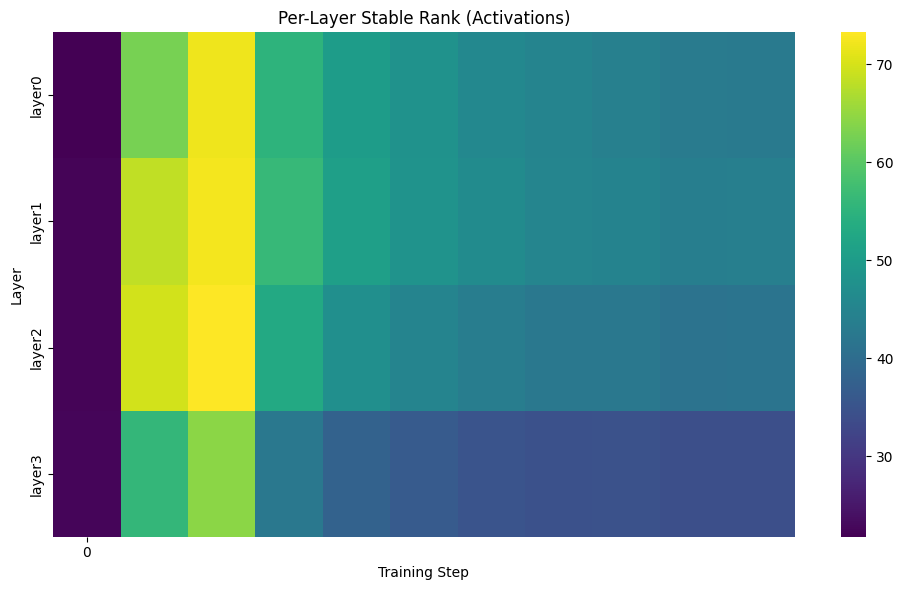

In [50]:
plot_layerwise_stable_rank(filtered[0])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import defaultdict
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10
})

def plot_all_metrics_for_task(experiments, save_dir="figures", task="copy"):
    save_path = Path(save_dir)
    save_path.mkdir(exist_ok=True, parents=True)

    exps = [e for e in experiments if e['task'] == task]
    if not exps:
        print(f"No {task} task experiments found!")
        return

    by_arch = defaultdict(list)
    for exp in exps:
        by_arch[exp['arch']].append(exp)

    metrics_to_plot = [
        'activation_stable_rank',
        'activation_top_sv',
        'token_cosine_mean',
        'token_cosine_std',
        'activation_variance',
        'eval_acc'
    ]

    for arch_type, arch_exps in by_arch.items():
        num_layers = len(arch_exps[0]['metrics'][0].get('per_layer', {}))
        by_reg = defaultdict(list)
        for exp in arch_exps:
            by_reg[exp['regularizer']].append(exp)

        # Regularizer colors
        colors = sns.color_palette("Set2", n_colors=len(by_reg))
        normal_color = 'black'

        for layer_idx in range(num_layers):
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            axes = axes.flatten()
            fig.suptitle(f'{task.capitalize()} Task - {arch_type} - Layer {layer_idx}', fontsize=16, fontweight='bold')

            for metric_idx, metric_name in enumerate(metrics_to_plot):
                ax = axes[metric_idx]

                # First plot non-normal regularizers
                for (reg_name, reg_exps), color in zip(by_reg.items(), colors):
                    if reg_name == 'normal':
                        continue

                    all_data = []
                    for exp in reg_exps:
                        for checkpoint in exp['metrics']:
                            step = checkpoint.get('step', 0)
                            layer_key = f'layer{layer_idx}'
                            per_layer = checkpoint.get('per_layer', {})
                            value = checkpoint.get(metric_name) if metric_name == 'eval_acc' else per_layer.get(layer_key, {}).get(metric_name, np.nan)
                            if not np.isnan(value):
                                all_data.append({'step': step, 'value': value})

                    if all_data:
                        df = pd.DataFrame(all_data).sort_values('step')
                        grouped = df.groupby('step')['value'].agg(['mean', 'std']).reset_index()
                        ax.plot(grouped['step'], grouped['mean'], label=reg_name,
                                linewidth=2, marker='o', markersize=5, color=color, alpha=0.8)
                        ax.fill_between(grouped['step'],
                                        grouped['mean'] - grouped['std'],
                                        grouped['mean'] + grouped['std'],
                                        color=color, alpha=0.15)

                # Then overlay normal baseline
                if 'normal' in by_reg:
                    all_data = []
                    for exp in by_reg['normal']:
                        for checkpoint in exp['metrics']:
                            step = checkpoint.get('step', 0)
                            layer_key = f'layer{layer_idx}'
                            per_layer = checkpoint.get('per_layer', {})
                            value = checkpoint.get(metric_name) if metric_name == 'eval_acc' else per_layer.get(layer_key, {}).get(metric_name, np.nan)
                            if not np.isnan(value):
                                all_data.append({'step': step, 'value': value})

                    if all_data:
                        df = pd.DataFrame(all_data).sort_values('step')
                        grouped = df.groupby('step')['value'].agg(['mean', 'std']).reset_index()
                        ax.plot(grouped['step'], grouped['mean'], label='normal',
                                linewidth=3, linestyle='--', color=normal_color)
                        ax.fill_between(grouped['step'],
                                        grouped['mean'] - grouped['std'],
                                        grouped['mean'] + grouped['std'],
                                        color=normal_color, alpha=0.1)

                ax.set_xlabel('Training Step', fontweight='bold')
                ax.set_ylabel(metric_name.replace('_', ' ').title(), fontweight='bold')
                ax.set_title(metric_name.replace('_', ' ').title(), fontweight='bold')
                ax.legend(framealpha=0.9)
                ax.grid(alpha=0.25)

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            fig_path = save_path / f"{task}_{arch_type}_layer{layer_idx}_all_metrics.png"
            plt.savefig(fig_path, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"✅ Saved: {fig_path}")


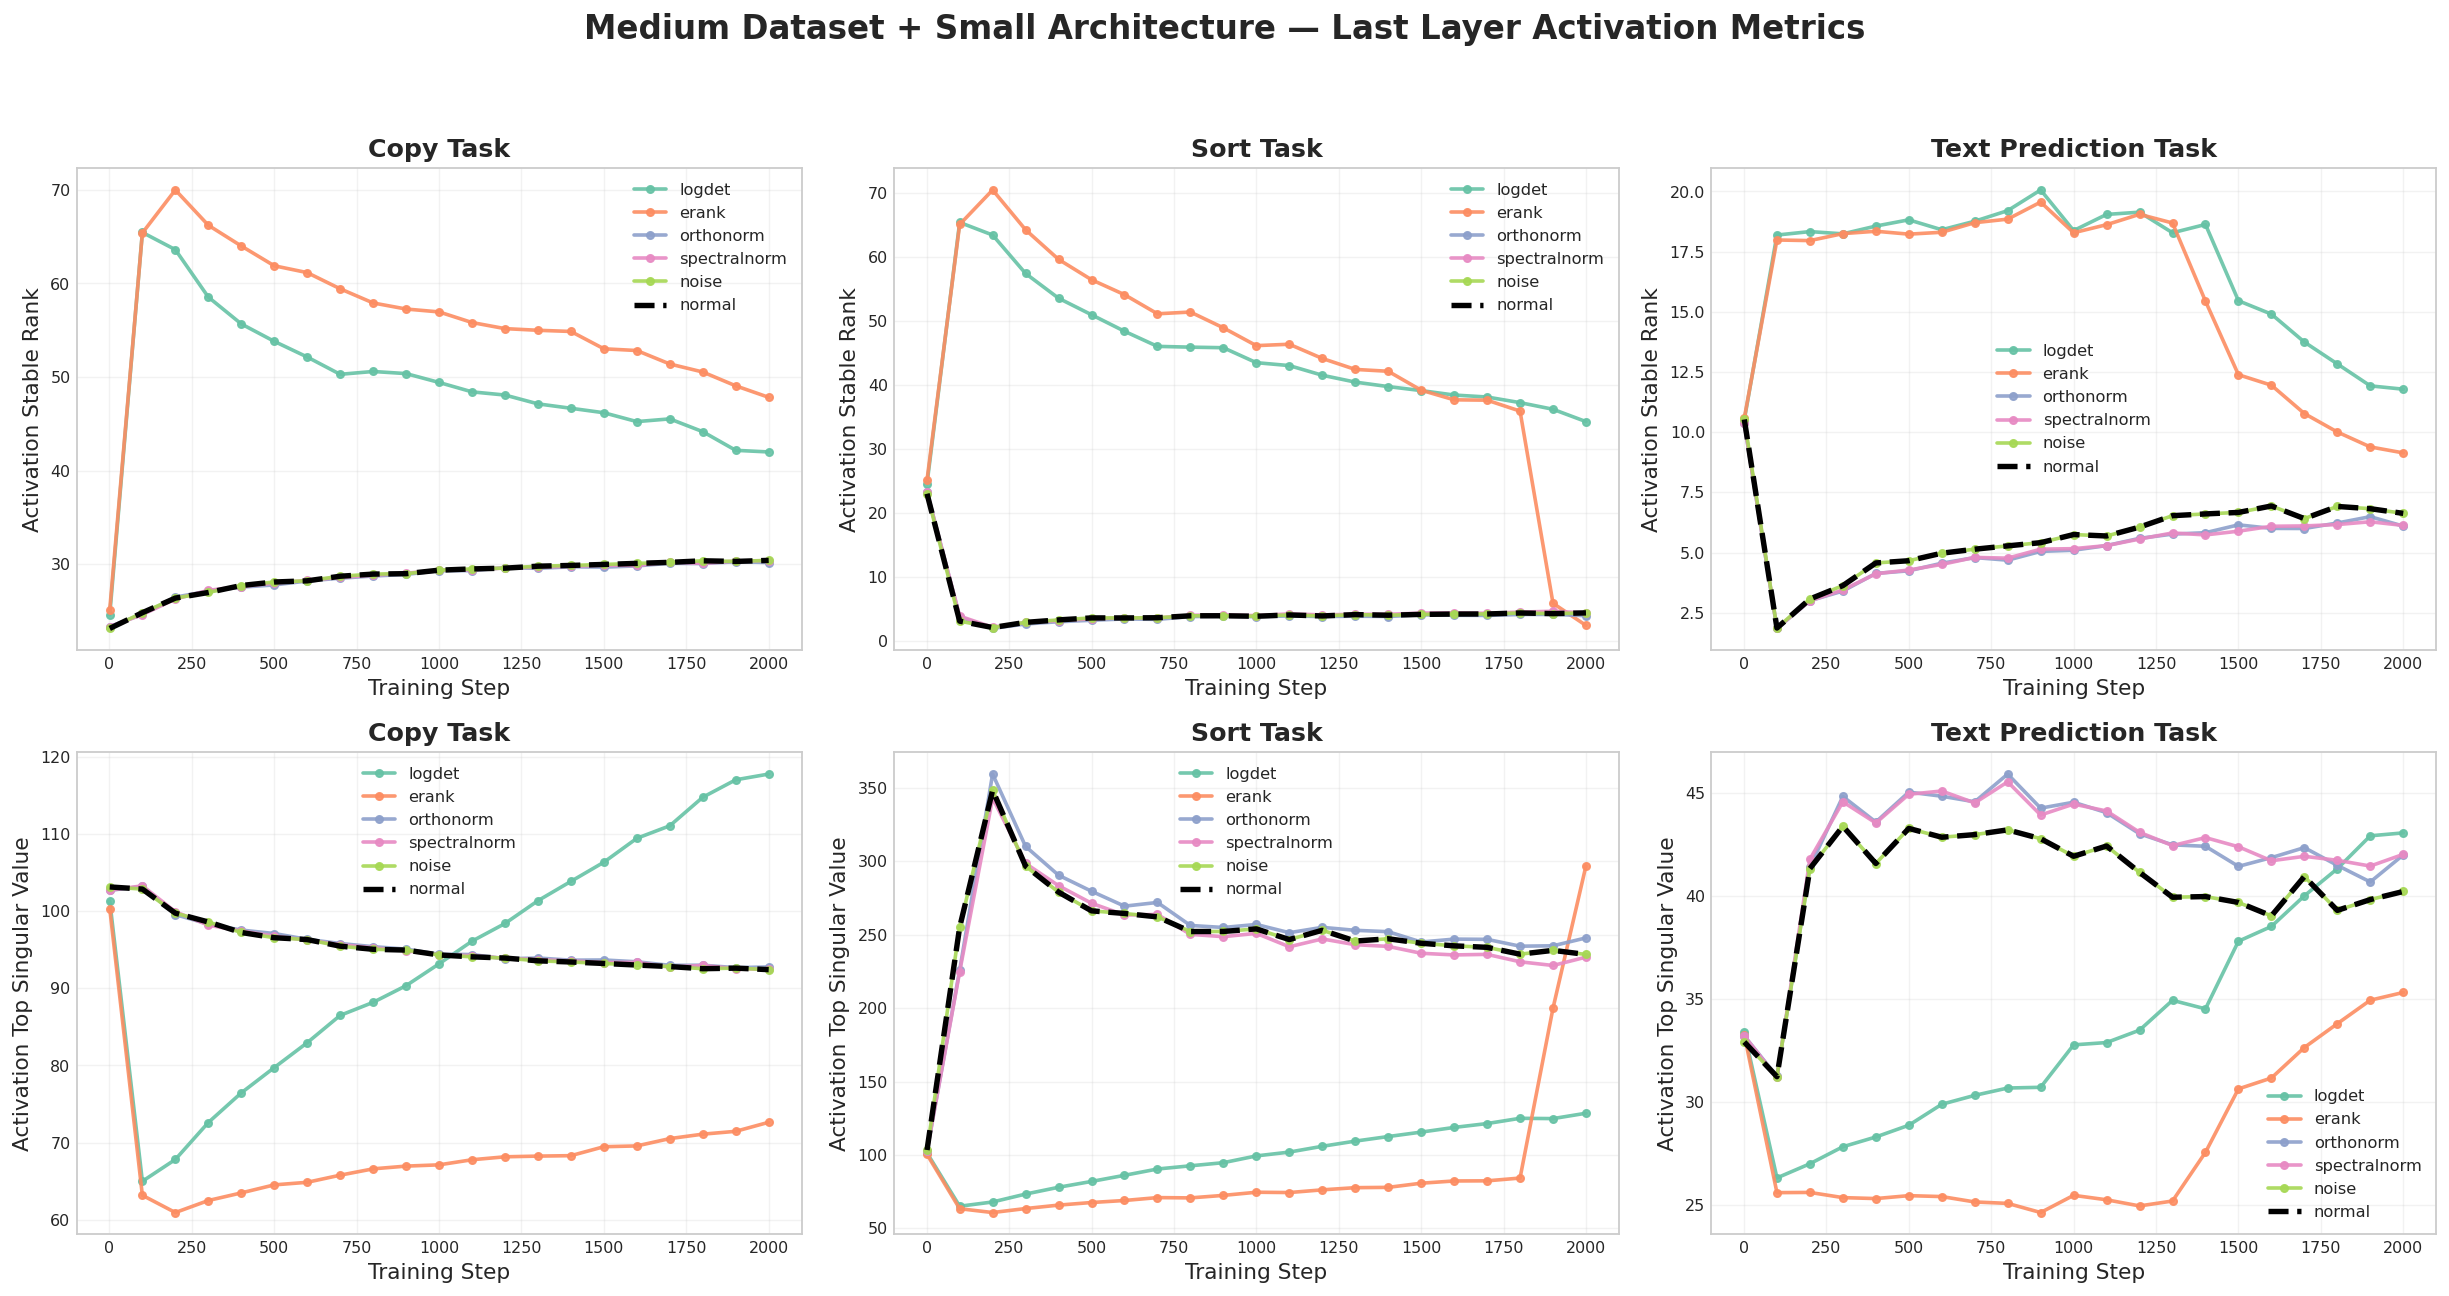

✓ Saved figs/small_ds_medium_last_layer_grid.png


In [173]:
def plot_medium_last_layer_grid(experiments, size="medium", arch="small"):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    from pathlib import Path
    from collections import defaultdict
    savepath=f"figs/{arch}_ds_{size}_last_layer_grid.png"

    sns.set_style("whitegrid")

    tasks = ["copy", "sort", "tinystories"]
    task_titles = ["Copy Task", "Sort Task", "Text Prediction Task"]

    metrics = [
        ("activation_stable_rank", "Activation Stable Rank"),
        ("activation_top_sv",      "Activation Top Singular Value"),
    ]

    non_normal_regs = ["logdet", "erank", "orthonorm", "spectralnorm", "noise"]
    all_regs = non_normal_regs + ["normal"]

    # --- color scheme: Set2 for non-normal, black dashed for normal ---
    colors = sns.color_palette("Set2", n_colors=len(non_normal_regs))
    reg_color = dict(zip(non_normal_regs, colors))
    reg_color["normal"] = "black"

    # --- Filter for medium dataset + medium arch ---
    exps = [
        e for e in experiments
        if e.get("dataset_size") == size and e.get("arch") == arch
    ]

    if not exps:
        print("❌ No medium-dataset medium-arch experiments found.")
        return

    # Determine last layer
    first = exps[0]["metrics"]
    per = next(m for m in first if "per_layer" in m)
    layer_names = sorted(per["per_layer"].keys())
    last_layer = layer_names[-1]

    # --- Build figure ---
    fig, axes = plt.subplots(2, 3, figsize=(19, 10))
    fig.suptitle(
        "Medium Dataset + Small Architecture — Last Layer Activation Metrics",
        fontsize=18, fontweight='bold', y=0.995
    )

    for row_idx, (metric_key, metric_title) in enumerate(metrics):
        for col_idx, task in enumerate(tasks):

            ax = axes[row_idx][col_idx]
            ax.set_title(task_titles[col_idx], fontsize=14)

            # Filter experiments for this task
            task_exps = [e for e in exps if e["task"] == task]
            if not task_exps:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                continue

            # Group experiments by regularizer
            by_reg = defaultdict(list)
            for exp in task_exps:
                by_reg[exp["regularizer"]].append(exp)

            # --- 1. Plot non-normal regularizers ---
            for reg in non_normal_regs:
                if reg not in by_reg:
                    continue

                all_rows = []
                for exp in by_reg[reg]:
                    for ckpt in exp["metrics"]:
                        step = ckpt.get("step", None)
                        layer_dict = ckpt.get("per_layer", {}).get(last_layer, {})
                        val = layer_dict.get(metric_key, np.nan)

                        if step is not None and not np.isnan(val):
                            all_rows.append((step, val))

                if not all_rows:
                    continue

                df = pd.DataFrame(all_rows, columns=["step", "value"]).sort_values("step")
                grouped = df.groupby("step")["value"].agg(["mean", "std"]).reset_index()

                ax.plot(
                    grouped["step"], grouped["mean"],
                    label=reg,
                    linewidth=2,
                    marker="o", markersize=4,
                    color=reg_color[reg],
                    alpha=0.9
                )
                ax.fill_between(
                    grouped["step"],
                    grouped["mean"] - grouped["std"],
                    grouped["mean"] + grouped["std"],
                    color=reg_color[reg],
                    alpha=0.12
                )

            # --- 2. Plot normal baseline (dashed black) ---
            if "normal" in by_reg:
                all_rows = []
                for exp in by_reg["normal"]:
                    for ckpt in exp["metrics"]:
                        step = ckpt.get("step", None)
                        layer_dict = ckpt.get("per_layer", {}).get(last_layer, {})
                        val = layer_dict.get(metric_key, np.nan)

                        if step is not None and not np.isnan(val):
                            all_rows.append((step, val))

                if all_rows:
                    df = pd.DataFrame(all_rows, columns=["step", "value"]).sort_values("step")
                    grouped = df.groupby("step")["value"].agg(["mean", "std"]).reset_index()

                    ax.plot(
                        grouped["step"], grouped["mean"],
                        label="normal",
                        linewidth=3,
                        linestyle="--",
                        color="black"
                    )
                    ax.fill_between(
                        grouped["step"],
                        grouped["mean"] - grouped["std"],
                        grouped["mean"] + grouped["std"],
                        color="black",
                        alpha=0.08
                    )

            ax.set_xlabel("Training Step")
            ax.set_ylabel(metric_title)
            ax.grid(alpha=0.25)
            ax.legend(framealpha=0.9, fontsize=9)

    plt.tight_layout(rect=[0,0,1,0.96])

    Path(savepath).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✓ Saved {savepath}")


plot_medium_last_layer_grid(experiments)

In [ ]:
experiments = load_all_logs(log_dir="/content/drive/MyDrive/DLFinalProject/rank-collapse/logs")

✅ Loaded: copy_large_tiny_normal_all_steps2000_seed42.npy (21 checkpoints)
✅ Loaded: copy_large_tiny_noise_all_steps2000_seed42.npy (21 checkpoints)
✅ Loaded: copy_large_small_normal_all_steps2000_seed42.npy (21 checkpoints)
✅ Loaded: copy_large_small_noise_all_steps2000_seed42.npy (21 checkpoints)
✅ Loaded: copy_large_medium_normal_all_steps2000_seed42.npy (21 checkpoints)
✅ Loaded: copy_large_medium_noise_all_steps2000_seed42.npy (21 checkpoints)
✅ Loaded: reverse_large_tiny_normal_all_steps2000_seed42.npy (21 checkpoints)
✅ Loaded: reverse_large_tiny_noise_all_steps2000_seed42.npy (21 checkpoints)
✅ Loaded: reverse_large_small_normal_all_steps2000_seed42.npy (21 checkpoints)
✅ Loaded: reverse_large_small_noise_all_steps2000_seed42.npy (21 checkpoints)
✅ Loaded: reverse_large_medium_normal_all_steps2000_seed42.npy (21 checkpoints)
✅ Loaded: reverse_large_medium_noise_all_steps2000_seed42.npy (21 checkpoints)
✅ Loaded: sort_large_tiny_normal_all_steps2000_seed42.npy (21 checkpoints)
✅

In [ ]:
plot_all_metrics_for_task(experiments=experiments, save_dir="/content/drive/MyDrive/DLFinalProject/rank-collapse/figures", task="copy")

✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/copy_tiny_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/copy_tiny_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/copy_small_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/copy_small_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/copy_small_layer2_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/copy_small_layer3_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/copy_medium_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/copy_medium_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/copy_medium_layer2_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/cop

In [ ]:
plot_all_metrics_for_task(experiments=experiments, save_dir="/content/drive/MyDrive/DLFinalProject/rank-collapse/figures", task="reverse")

✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/reverse_tiny_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/reverse_tiny_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/reverse_small_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/reverse_small_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/reverse_small_layer2_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/reverse_small_layer3_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/reverse_medium_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/reverse_medium_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/reverse_medium_layer2_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProjec

In [ ]:
plot_all_metrics_for_task(experiments=experiments, save_dir="/content/drive/MyDrive/DLFinalProject/rank-collapse/figures", task="sort")

✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/sort_tiny_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/sort_tiny_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/sort_small_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/sort_small_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/sort_small_layer2_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/sort_small_layer3_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/sort_medium_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/sort_medium_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/sort_medium_layer2_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/sor

In [ ]:
plot_all_metrics_for_task(experiments=experiments, save_dir="/content/drive/MyDrive/DLFinalProject/rank-collapse/figures", task="tinystories")

✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/tinystories_tiny_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/tinystories_tiny_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/tinystories_small_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/tinystories_small_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/tinystories_small_layer2_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/tinystories_small_layer3_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/tinystories_medium_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/tinystories_medium_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/tinystories_medium_layer2_all_metrics.png
✅ Saved: 

In [ ]:
plot_all_metrics_for_task(experiments=experiments, save_dir="/content/drive/MyDrive/DLFinalProject/rank-collapse/figures", task="text")

✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/text_tiny_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/text_tiny_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/text_small_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/text_small_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/text_small_layer2_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/text_small_layer3_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/text_medium_layer0_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/text_medium_layer1_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/text_medium_layer2_all_metrics.png
✅ Saved: /content/drive/MyDrive/DLFinalProject/rank-collapse/figures/tex

In [ ]:
import numpy as np

def print_unique_keys(obj, indent=0, seen_signatures=None, max_depth=5):
    """
    Recursively print dict/list keys, skipping repeated structures.
    """
    if seen_signatures is None:
        seen_signatures = set()
    prefix = "    " * indent
    if indent > max_depth:
        return

    if isinstance(obj, dict):
        sig = tuple(sorted(obj.keys()))
        if sig in seen_signatures:
            return  # skip repeated structure entirely
        seen_signatures.add(sig)
        print(prefix + "dict keys:", list(obj.keys()))
        for k, v in obj.items():
            print_unique_keys(v, indent + 1, seen_signatures, max_depth)
    elif isinstance(obj, list):
        if len(obj) == 0:
            return
        print(prefix + f"list of length {len(obj)}")
        print_unique_keys(obj[0], indent + 1, seen_signatures, max_depth)
    else:
        # primitive type
        return

def inspect_npy_structure(path, max_depth=5):
    print(f"\nLoading {path}")
    data = np.load(path, allow_pickle=True)
    if isinstance(data, np.ndarray) and len(data) > 0:
        print("\nTop-level keys (first element):")
        print_unique_keys(data[0], max_depth=max_depth)
    else:
        print_unique_keys(data, max_depth=max_depth)
    return data


In [ ]:
data = inspect_npy_structure("/content/drive/MyDrive/DLFinalProject/rank-collapse/logs/copy_large_large_erank_all_steps2000_seed42.npy")



Loading /content/drive/MyDrive/DLFinalProject/rank-collapse/logs/copy_large_large_erank_all_steps2000_seed42.npy

Top-level keys (first element):
dict keys: ['step', 'time', 'train_loss', 'train_acc', 'eval_loss', 'eval_acc', 'per_layer']
    dict keys: ['layer0', 'layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7']
        dict keys: ['attn_mean_metrics', 'attn_cov_eigs_per_head', 'weights', 'activation_svals', 'activation_stable_rank', 'activation_top_sv', 'activation_pca_explained', 'token_cosine_mean', 'token_cosine_std', 'activation_variance']
            dict keys: ['head_stable_mean', 'head_stable_std', 'head_stable_min', 'head_stable_max', 'head_entropy_mean', 'head_top1_mean', 'mean_stable', 'mean_entropy_rank', 'mean_top1', 'mean_top3', 'mean_top5', 'sparsity', 'mean_attn', 'std_attn']
            list of length 16
            dict keys: ['Wq', 'Wk', 'Wv', 'Wo', 'W1', 'W2']
                dict keys: ['svals', 'rank', 'stable_rank', 'top_sv', 'fro_norm']


📂 Scanning directory: /content/drive/MyDrive/DLFinalProject/rank-collapse/logs/0.01
  Loaded: copy_small_tiny_expandEarlyThenCollapseLate_steps2000_seed42.npy
  Loaded: copy_small_tiny_collapseEarlyOnly_steps2000_seed42.npy
  Loaded: copy_small_tiny_expandEarlyOnly_steps2000_seed42.npy
  Loaded: copy_small_small_collapseEarlyThenExpandLate_steps2000_seed42.npy
  Loaded: copy_small_small_expandEarlyThenCollapseLate_steps2000_seed42.npy
  Loaded: copy_small_small_collapseEarlyOnly_steps2000_seed42.npy
  Loaded: copy_small_small_expandEarlyOnly_steps2000_seed42.npy
  Loaded: copy_small_medium_collapseEarlyThenExpandLate_steps2000_seed42.npy
  Loaded: copy_small_medium_expandEarlyThenCollapseLate_steps2000_seed42.npy
  Loaded: copy_small_medium_collapseEarlyOnly_steps2000_seed42.npy
  Loaded: copy_small_medium_expandEarlyOnly_steps2000_seed42.npy
  Loaded: copy_medium_tiny_collapseEarlyThenExpandLate_steps2000_seed42.npy
  Loaded: copy_medium_tiny_expandEarlyThenCollapseLate_steps2000_seed

KeyboardInterrupt: 

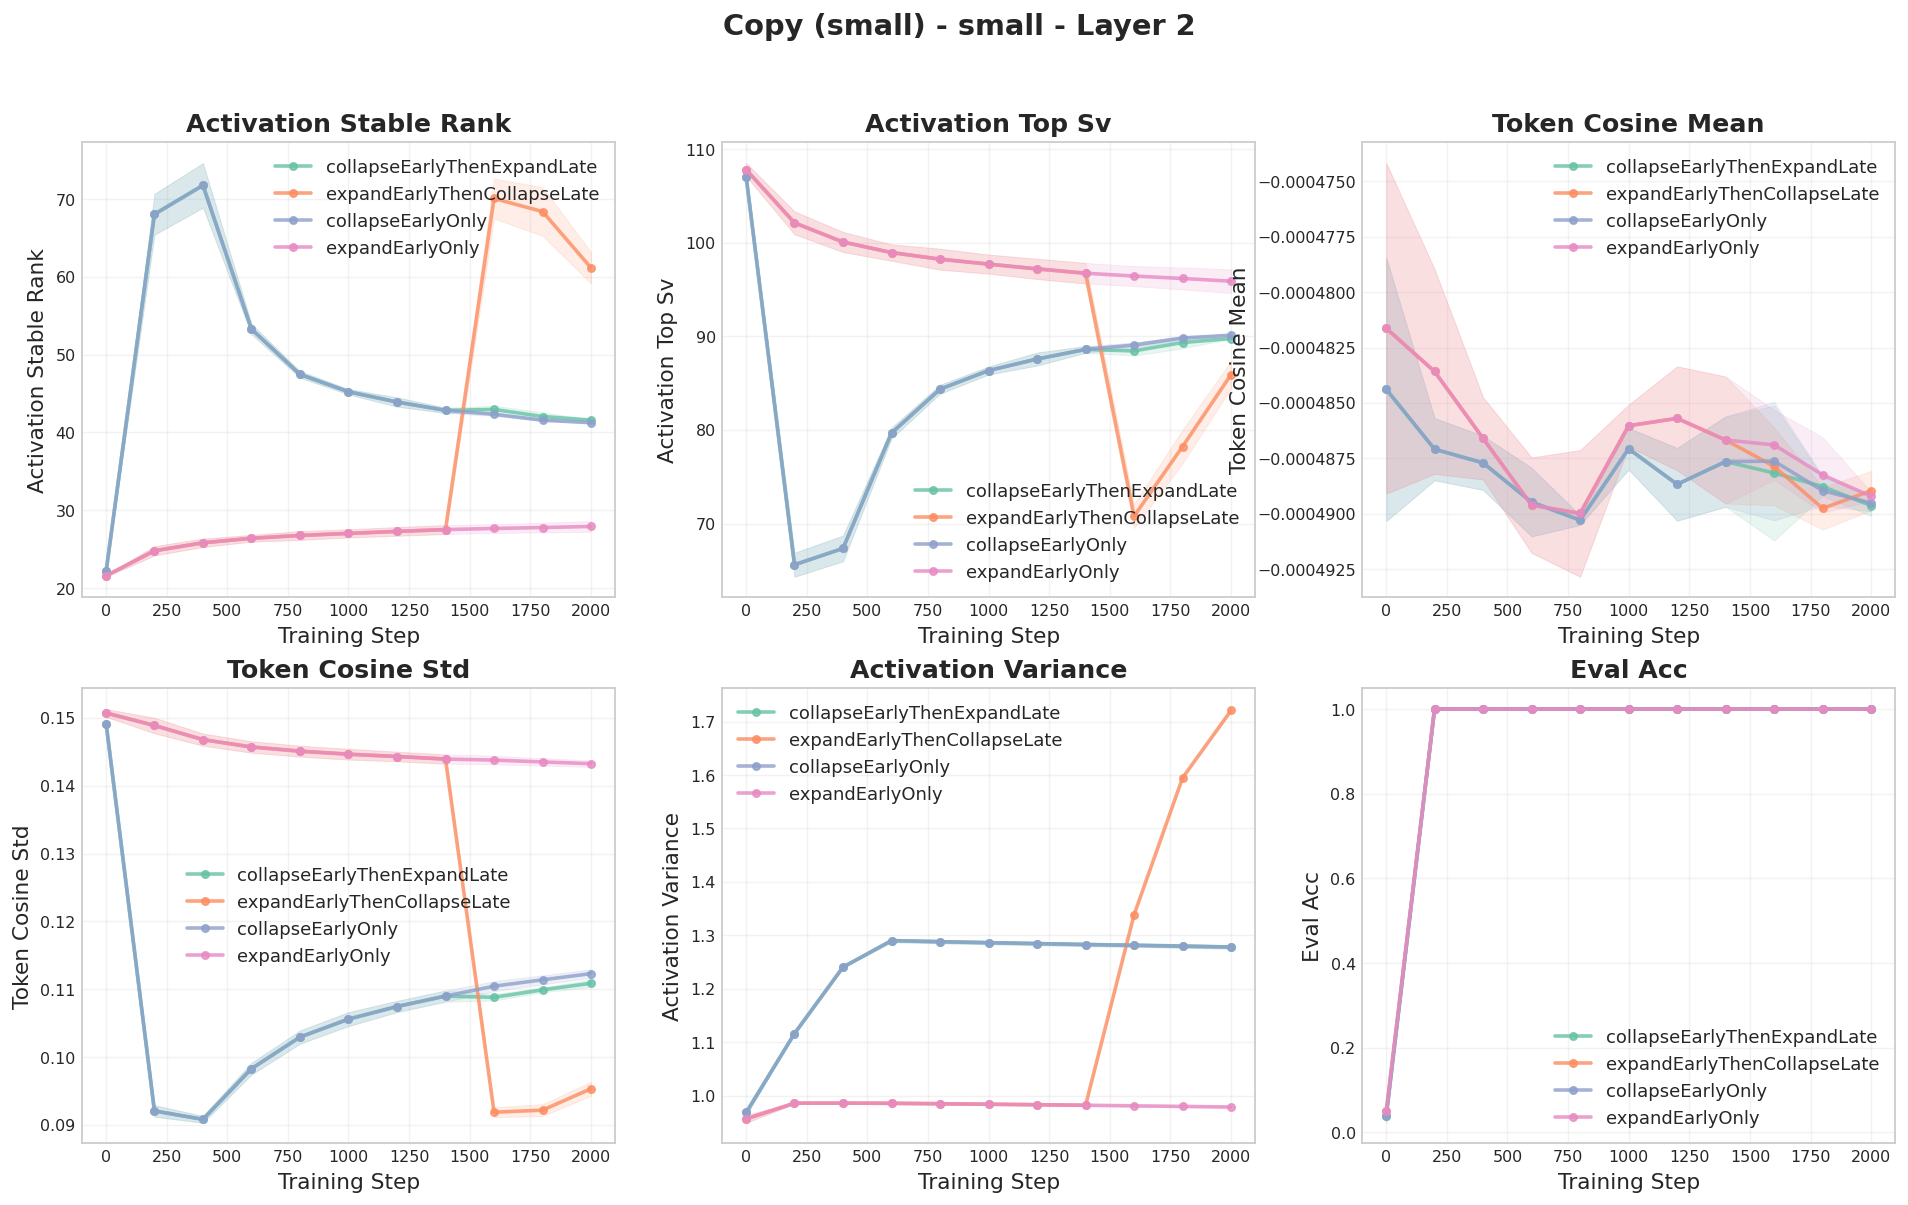

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import defaultdict
from pathlib import Path

# --- Configuration ---
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10
})

def parse_filename(filename):
    """
    Parses filenames like: reverse_small_tiny_expandEarlyThenCollapseLate_steps2000_seed42
    Returns a dictionary of metadata.
    """
    parts = filename.split('_')

    # flexible parsing to handle potential underscores in regularizer names if strict format isn't guaranteed
    # But based on your example, we assume standard position mapping:
    # 0: Task, 1: Dataset Size, 2: Model Size, 3: Regularizer, 4: Steps, 5: Seed

    if len(parts) < 6:
        print(f"⚠️ Warning: Filename '{filename}' does not match expected format. Skipping.")
        return None

    return {
        'task': parts[0],
        'dataset_size': parts[1],
        'arch': parts[2],            # Maps 'tiny' -> arch
        'regularizer': parts[3],     # Maps 'expandEarlyThenCollapseLate' -> regularizer
        'steps': parts[4],
        'seed': parts[5]
    }

def load_experiments_from_npy(data_dir):
    """
    Loads all .npy files from the directory and structures them for analysis.
    """
    data_path = Path(data_dir)
    experiments = []

    print(f"📂 Scanning directory: {data_path}")
    files = list(data_path.glob("*.npy"))

    if not files:
        print("❌ No .npy files found!")
        return []

    for file_path in files:
        meta = parse_filename(file_path.stem)
        if not meta:
            continue

        try:
            # Load the NPY file
            # allow_pickle=True is needed if the NPY contains a list of dicts or object arrays
            raw_data = np.load(file_path, allow_pickle=True)

            # If data is wrapped in a 0-d array (common with np.save), extract it
            if raw_data.ndim == 0:
                raw_data = raw_data.item()

            # Combine metadata with the actual metrics data
            exp_entry = {
                **meta,
                'metrics': raw_data  # Assumes raw_data is the list of checkpoint dicts
            }
            experiments.append(exp_entry)
            print(f"  Loaded: {file_path.name}")

        except Exception as e:
            print(f"❌ Error loading {file_path.name}: {e}")

    print(f"✅ Successfully loaded {len(experiments)} experiments.\n")
    return experiments

def plot_all_metrics_for_task(experiments, save_dir="figures", task="reverse"):
    save_path = Path(save_dir)
    save_path.mkdir(exist_ok=True, parents=True)

    # Filter experiments by task
    exps = [e for e in experiments if e['task'] == task]
    if not exps:
        print(f"⚠️ No experiments found for task: '{task}'")
        return

    # Group by Architecture (Model Size) -> e.g., 'tiny'
    by_arch = defaultdict(list)
    for exp in exps:
        by_arch[exp['arch']].append(exp)

    metrics_to_plot = [
        'activation_stable_rank',
        'activation_top_sv',
        'token_cosine_mean',
        'token_cosine_std',
        'activation_variance',
        'eval_acc'
    ]

    for arch_type, arch_exps in by_arch.items():
        # Determine number of layers dynamically from the first valid experiment
        try:
            sample_metrics = arch_exps[0]['metrics']
            # Find a checkpoint that has 'per_layer' info (some early steps might not)
            sample_ckpt = next((m for m in sample_metrics if 'per_layer' in m), None)

            if not sample_ckpt:
                print(f"⚠️ Could not find per_layer data for {arch_type}. Skipping.")
                continue

            num_layers = len(sample_ckpt['per_layer'])
        except (IndexError, KeyError, TypeError) as e:
            print(f"⚠️ Error determining layers for {arch_type}: {e}")
            continue

        # Group by Regularizer
        by_reg = defaultdict(list)
        for exp in arch_exps:
            by_reg[exp['regularizer']].append(exp)

        colors = sns.color_palette("Set2", n_colors=len(by_reg))
        normal_color = 'black'

        for layer_idx in range(num_layers):
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            axes = axes.flatten()

            # Use arch_type (tiny) and task in title
            dataset_size = arch_exps[0]['dataset_size'] # Grab dataset size from first exp
            fig.suptitle(f'{task.capitalize()} ({dataset_size}) - {arch_type} - Layer {layer_idx}',
                         fontsize=16, fontweight='bold')

            for metric_idx, metric_name in enumerate(metrics_to_plot):
                ax = axes[metric_idx]
                has_data = False

                # 1. Plot non-normal regularizers
                color_idx = 0
                for reg_name, reg_exps in by_reg.items():
                    if reg_name == 'normal':
                        continue

                    # Cycle colors safely
                    color = colors[color_idx % len(colors)]
                    color_idx += 1

                    all_data = []
                    for exp in reg_exps:
                        for checkpoint in exp['metrics']:
                            step = checkpoint.get('step', 0)

                            val = np.nan
                            if metric_name == 'eval_acc':
                                val = checkpoint.get(metric_name, np.nan)
                            else:
                                layer_data = checkpoint.get('per_layer', {}).get(f'layer{layer_idx}', {})
                                val = layer_data.get(metric_name, np.nan)

                            if not np.isnan(val):
                                all_data.append({'step': step, 'value': val})

                    if all_data:
                        has_data = True
                        df = pd.DataFrame(all_data).sort_values('step')
                        grouped = df.groupby('step')['value'].agg(['mean', 'std']).reset_index()

                        ax.plot(grouped['step'], grouped['mean'], label=reg_name,
                                linewidth=2, marker='o', markersize=4, color=color, alpha=0.8)
                        ax.fill_between(grouped['step'],
                                        grouped['mean'] - grouped['std'],
                                        grouped['mean'] + grouped['std'],
                                        color=color, alpha=0.15)

                # 2. Overlay normal baseline
                if 'normal' in by_reg:
                    all_data = []
                    for exp in by_reg['normal']:
                        for checkpoint in exp['metrics']:
                            step = checkpoint.get('step', 0)

                            val = np.nan
                            if metric_name == 'eval_acc':
                                val = checkpoint.get(metric_name, np.nan)
                            else:
                                layer_data = checkpoint.get('per_layer', {}).get(f'layer{layer_idx}', {})
                                val = layer_data.get(metric_name, np.nan)

                            if not np.isnan(val):
                                all_data.append({'step': step, 'value': val})

                    if all_data:
                        has_data = True
                        df = pd.DataFrame(all_data).sort_values('step')
                        grouped = df.groupby('step')['value'].agg(['mean', 'std']).reset_index()

                        ax.plot(grouped['step'], grouped['mean'], label='normal',
                                linewidth=3, linestyle='--', color=normal_color)
                        ax.fill_between(grouped['step'],
                                        grouped['mean'] - grouped['std'],
                                        grouped['mean'] + grouped['std'],
                                        color=normal_color, alpha=0.1)

                ax.set_xlabel('Training Step')
                ax.set_ylabel(metric_name.replace('_', ' ').title())
                ax.set_title(metric_name.replace('_', ' ').title())
                if has_data:
                    ax.legend(framealpha=0.9)
                ax.grid(alpha=0.25)

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            fig_path = save_path / f"{task}_{dataset_size}_{arch_type}_layer{layer_idx}.png"
            plt.savefig(fig_path, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"  Saved figure: {fig_path.name}")

# --- Main Execution ---
if __name__ == "__main__":
    # Update this path to where your .npy files are stored
    DATA_DIRECTORY = "/content/drive/MyDrive/DLFinalProject/rank-collapse/logs/0.01"

    # Load data
    experiments_data = load_experiments_from_npy(DATA_DIRECTORY)

    # Run Plotting
    # Note: 'task' here must match the first word in your filename (e.g., 'reverse')
    if experiments_data:
        plot_all_metrics_for_task(experiments_data, save_dir="figures", task="copy")

In [ ]:
plot_all_metrics_for_task(experiments_data, save_dir="figures", task="copy")

  Saved figure: copy_small_tiny_layer0.png
  Saved figure: copy_small_tiny_layer1.png
  Saved figure: copy_small_small_layer0.png
  Saved figure: copy_small_small_layer1.png
  Saved figure: copy_small_small_layer2.png
  Saved figure: copy_small_small_layer3.png
  Saved figure: copy_small_medium_layer0.png
  Saved figure: copy_small_medium_layer1.png
  Saved figure: copy_small_medium_layer2.png
  Saved figure: copy_small_medium_layer3.png
  Saved figure: copy_small_medium_layer4.png
  Saved figure: copy_small_medium_layer5.png


In [ ]:
plot_all_metrics_for_task(experiments_data, save_dir="figures", task="sort")

⚠️ No experiments found for task: 'sort'


In [ ]:
plot_all_metrics_for_task(experiments_data, save_dir="figures", task="text")

⚠️ No experiments found for task: 'text'
